# Курсовая работа
**На тему: "Предварительный анализ данных и построение признаков в задачах оценки активов"**

**Выполнил: Белянинов Илья**

In [1]:
import pandas as pd
import numpy as np
from numpy import argmax
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.model_selection import KFold, cross_val_score
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

# Введение

В современном финансовом мире инвесторы все более заинтересованы в поиске перспективных компаний, способных обеспечить стабильный доход в виде дивидендов. Однако, предсказание того, какие из эмитентов начнут выплачивать дивиденды в будущем, остается сложной задачей, требующей разработки методов предварительного анализа данных и построения признаков.

Инвесторам также важно приобретать активы по более выгодной цене. Один из способов сделать это - раннее выявление компаний, которые в будущем могут начать выплачивать дивиденды. Подобный подход позволяет инвесторам приобрести акции по более низкой цене, чем после публичного объявления о планах выплаты дивидендов. Таким образом, проблема предсказания дивидендной доходности становится критически важной для инвесторов, стремящихся оптимизировать свои инвестиционные стратегии и повысить эффективность своих рыночных операций, особенно в условиях быстро меняющегося финансового мира и повышенной конкуренции.

В этом контексте разработка точных и надежных методов анализа данных и моделей прогнозирования становится неотложной задачей. Не только предсказание будущих дивидендных выплат, но и их своевременное распознавание может стать ключом к успешной стратегии инвестирования. В свете растущей доступности данных и развития аналитических инструментов, создание эффективных моделей прогнозирования становится более реальным, открывая новые возможности для инвесторов в поиске выгодных инвестиционных решений.

**Цель:** поиск эмитентов, которые в перспективе могут начать выплачивать дивиденды.\
**Бизнес-задача:** используя финансовые показатели, определить наличие дивидендной доходности у эмитента.\
**Задача машинного обучения:** бинарная классификация (1 – присутствует дивидендная доходность, 0 – отсутствует дивидендная доходность)

# 1. Предобработка и предварительный анализ данных

## 1.1. Импорт и анализ датасета

In [2]:
df = pd.read_excel('Финансовые показатели эмитентов.xlsx', sheet_name='Данные')
df

,№,Эмитент,Тикер,Наличие ДД,"Выручка, млрд руб","Операционная прибыль, млрд руб","EBITDA, млрд руб","Чистая прибыль, млрд руб","Операционный денежный поток, млрд руб","CAPEX, млрд руб",...,"Доходность FCF, %","ROE, %","ROA, %",P/E,P/FCF,P/S,P/BV,EV/EBITDA,Долг/EBITDA,Банковский сектор
0,1,Артген биотех (ИСКЧ),ABIO,1,1.14,0.11,0.164,0.046,0.220,0.218,...,-0.007,0.135,0.023,NaN,-136.90,9.37,-27.00,68.00,3.09,0
1,2,Абрау-Дюрсо,ABRD,1,13.80,2.74,3.380,1.750,0.805,1.360,...,-0.036,0.139,0.071,16.80,-27.90,2.13,2.33,10.80,2.11,0
2,3,АФК Система,AFKS,1,912.70,161.25,271.800,19.400,49.000,158.600,...,-1.042,0.185,0.009,12.70,-0.96,0.27,-1.60,4.32,3.41,0
3,4,Аэрофлот,AFLT,0,413.30,-13.37,112.900,-41.400,79.300,7.500,...,-0.255,0.453,-0.043,-4.99,-3.92,0.50,-2.20,6.29,4.46,0
4,5,Русагро,AGRO,0,240.20,19.06,45.000,6.800,4.420,12.900,...,-0.052,0.044,0.017,31.00,-19.30,0.88,1.40,6.72,2.03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,177,ЦМТ,WTCM,1,6.87,0.77,1.300,0.670,2.120,0.470,...,0.247,0.014,0.012,32.20,4.55,3.14,0.45,13.90,-2.68,0
177,178,Вуш Холдинг | WHOOSH,WUSH,0,6.96,1.41,2.520,0.830,2.150,3.750,...,-0.111,0.170,0.073,42.70,-9.01,5.09,7.31,15.20,1.14,0
178,179,ЯТЭК,YAKG,0,7.58,2.99,3.320,1.830,3.350,6.380,...,-0.021,0.130,0.063,43.60,-48.00,10.50,5.66,26.40,2.31,0
179,180,Якутскэнерго,YKEN,0,25.30,12.14,5.300,8.000,0.670,5.950,...,-4.055,-10.667,0.153,0.88,-0.29,0.28,-9.38,7.51,6.18,0


В датасете представлены 181 эмитентов и их финансовые показатели, полученные из годовых финансовых отчетностей МСФО за 2022 или 2021 годы

## 1.2.	Вывод количественных характеристик датасета и информации о пропущенных значениях

In [3]:
print("Общая информация о датасете:")
print(df.info())

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   №                                      181 non-null    int64  
 1   Эмитент                                181 non-null    object 
 2   Тикер                                  181 non-null    object 
 3   Наличие ДД                             181 non-null    int64  
 4   Выручка, млрд руб                      167 non-null    float64
 5   Операционная прибыль, млрд руб         154 non-null    float64
 6   EBITDA, млрд руб                       151 non-null    float64
 7   Чистая прибыль, млрд руб               177 non-null    float64
 8   Операционный денежный поток, млрд руб  157 non-null    float64
 9   CAPEX, млрд руб                        161 non-null    float64
 10  FCF, млрд руб                          154 no

Категориальных признаков в датасете нет. Все необходимые для анализа признаки в числовом формате

In [4]:
print("Основные статистические характеристики:")
df.describe()

Основные статистические характеристики:


,№,Наличие ДД,"Выручка, млрд руб","Операционная прибыль, млрд руб","EBITDA, млрд руб","Чистая прибыль, млрд руб","Операционный денежный поток, млрд руб","CAPEX, млрд руб","FCF, млрд руб","Опер. расходы, млрд руб",...,"Доходность FCF, %","ROE, %","ROA, %",P/E,P/FCF,P/S,P/BV,EV/EBITDA,Долг/EBITDA,Банковский сектор
count,181.000000,181.000000,167.000000,154.000000,151.000000,177.000000,157.000000,161.000000,154.000000,156.000000,...,160.000000,169.000000,168.000000,177.000000,153.000000,166.000000,165.000000,151.000000,150.000000,181.000000
mean,91.000000,0.408840,387.452946,57.350688,114.240967,43.206684,65.210000,50.957217,18.781487,167.660494,...,0.002338,-0.025822,0.069055,27.317062,16.404379,2.879096,0.585152,7.353576,1.000467,0.077348
std,52.394338,0.492983,1340.590640,212.779423,415.210279,178.716316,259.240443,211.684498,119.358555,786.739789,...,0.532543,2.218972,0.129316,132.256699,292.034901,7.399314,48.625212,25.914153,3.376556,0.267884
min,1.000000,0.000000,0.000000,-44.150000,-7.400000,-668.000000,-170.300000,0.000000,-201.000000,0.025000,...,-4.055000,-22.960000,-0.400000,-404.700000,-723.800000,0.020000,-550.300000,-269.400000,-20.400000,0.000000
25%,46.000000,0.000000,12.050000,0.882000,1.695000,0.335000,0.530000,0.400000,-0.874250,2.697500,...,-0.048250,0.033000,0.013750,3.670000,-3.820000,0.352500,0.380000,3.205000,-0.197500,0.000000
50%,91.000000,0.000000,55.400000,4.395000,9.380000,2.710000,4.220000,3.930000,0.700000,23.800000,...,0.052500,0.131000,0.043500,10.600000,3.250000,0.770000,1.420000,6.310000,1.020000,0.000000
75%,136.000000,1.000000,200.950000,25.655000,48.700000,18.700000,29.300000,18.000000,6.967500,74.900000,...,0.214250,0.299000,0.132000,25.900000,7.620000,2.210000,4.070000,10.550000,2.185000,0.000000
max,181.000000,1.000000,11674.000000,1935.200000,3638.000000,1312.000000,2193.000000,2192.000000,989.000000,9307.000000,...,1.334000,10.463000,0.587000,1488.000000,3503.000000,61.100000,247.200000,111.000000,12.800000,1.000000


In [5]:
missing_values = df.isnull().sum()
print("\nПропущенные значения в каждом столбце:")
print(missing_values)


Пропущенные значения в каждом столбце:
№                                         0
Эмитент                                   0
Тикер                                     0
Наличие ДД                                0
Выручка, млрд руб                        14
Операционная прибыль, млрд руб           27
EBITDA, млрд руб                         30
Чистая прибыль, млрд руб                  4
Операционный денежный поток, млрд руб    24
CAPEX, млрд руб                          20
FCF, млрд руб                            27
Опер. расходы, млрд руб                  25
Себестоимость, млрд руб                  78
Расх. на персонал, млрд руб              26
Процентные расходы, млрд руб             38
Активы, млрд руб                         16
Чистые активы, млрд руб                  17
Наличность, млрд руб                      9
Чистый долг, млрд руб                     5
Капитализация, млрд руб                   0
EV, млрд руб                              0
Балансовая стоимость, млрд руб      

В данных присутсвуют пропущенные значения. В столбце **Себестоимость, млрд руб** их больше, чем в других столбцах

## 1.3.	Исследование физического смысла и значимости каждого атрибута данных

##### Физический смысл каждого атрибута данных

**№** - Порядковый номер записи.

**Эмитент** - Название компании-эмитента.

**Тикер** - Торговый символ компании.

**Наличие ДД** - Наличие дивидендной доходности у компании. 1 - присутствует дивидендная доходность, 0 - отсутствует дивидендная доходность

**Выручка, млрд руб** - Полная сумма денежных средств, полученная предприятием или предпринимателем от реализации всей или части произведённой продукции, услуг, работ за определённый период.

**Операционная прибыль, млрд руб** - Отражает ту прибыль, которая была получена после вычета всех расходов, которые были связаны с реализацией.

**EBITDA, млрд руб** - Earnings before interest, taxes, depreciation and amortization - аналитический показатель, равный объёму прибыли до вычета расходов по уплате налогов, процентов, и начисленной амортизации.

**Чистая прибыль, млрд руб** - Это те деньги, которые остаются в компании по итогам отчетного периода после всех расходов и уплаты налогов и могут быть распределены между акционерами в виде дивидендов.

**Операционный денежный поток, млрд руб** - Чистая сумма денежных средств, которую компания заработала от операционной деятельности

**CAPEX, млрд руб** - Это сокращение от английского Capital Expenditures — капитальные затраты. CAPEX — это основная часть затрат инвестиционных проектов. В CAPEX входят затраты на приобретение основных средств, например, здания, оборудование, технологии и другие затраты.

**FCF, млрд руб** - Free Cash Flow — свободный денежный поток компании. Это сумма свободных денежных средств, которая остается после того, как из операционного денежного потока вычли расходы на капитальные затраты. Свободный денежный поток — это такая сумма денег, которую можно изъять из бизнеса без ущерба для будущей деятельности, так при её расчете были учтены внутренние потребности компании.

**Опер. расходы, млрд руб** - Затраты и платежи, связанные с проведением производственно-хозяйственных и финансовых операций за определенный период времени.

**Себестоимость, млрд руб** - Стоимость всех затрат на создание и реализацию товаров, работ или услуг.

**Расх. на персонал, млрд руб** - Это показатель, который объединяет все прямые и косвенные расходы организации на поиск кадров, трудоустройство, организацию и оплату труда, повышение квалификации и многое другое

**Процентные расходы, млрд руб** - Это затраты, понесённые предприятием в связи с привлечением заёмных средств. Они представляют собой проценты, подлежащие уплате по любым займам — облигациям, займам, конвертируемому долгу или кредитным линиям.

**Активы, млрд руб** - Это ресурсы, стоимость которых может быть оценена и от которых компания ожидает получение экономических выгод.

**Чистые активы, млрд руб** - Это реальная стоимость имущества компании, за вычетом его долгов. Чистые активы компании рассчитываются как разница между активами компании и ее обязательствами.

**Наличность, млрд руб** - Депозиты в банках, доступные для текущих операций на время составления баланса, а также наличные деньги (в кассе компании) и деньги на руках, включая валюту, платежные поручения, тратты.

**Чистый долг, млрд руб** - Это показатель, который рассчитывается как общий долг, из которого вычли все имеющиеся у компании, доступные в настоящее время денежные средства и их эквиваленты.

**Капитализация, млрд руб** - Это рыночная стоимость предприятия. Она представляет собой произведение количества акций компании на их текущую стоимость.

**EV, млрд руб** - Enterprise Value - стоимость компании с учетом всех источников ее финансирования; долговых обязательств, привилегированных акций, доли меньшинства и обыкновенных акций компании.
Расчет: EV = Market Capitalization + Net Debt (Рыночная капитализация компании + Чистый долг).

**Балансовая стоимость, млрд руб** - Это денежная стоимость всех основных средств и нематериальных активов компании, по которой они принимаются к бухгалтерскому учёту.

**EPS, руб** - Earnings Per Share — показатель прибыли на акцию. По сути, обратен соотношению P/E. Но в отличие от P/E, мультипликатор EPS меняется в случае допэмиссии (прибыль на 1 акцию становится меньше).

**FCF/акцию, руб** - Свободный денежный поток (FCF) на акцию компании в рублях.

**BV/акцию, руб** - Балансовая стоимость на акцию компании в рублях.

**Рентабельность EBITDA, %** - EBITDA Margin — рентабельность по показателю EBITDA, то есть отношение EBITDA/выручка. Это относительный показатель. Данный коэффициент отражает прибыльность компании до уплаты процентов, налогов и амортизации.

**Чистая рентабельность, %** - Net margin — отношение чистой прибыли компании к ее выручке.

**Доходность FCF, %** - Доходность от свободного денежного потока, измеряет, сколько процентов от текущей рыночной капитализации компании составляет ее свободный денежный поток. Этот показатель позволяет инвесторам оценить, насколько эффективно компания генерирует денежные средства после вычета всех операционных и капитальных расходов.

**ROE, %** - Return On Equity - Рентабельность собственного капитала – отношение чистой прибыли за период к средневзвешенной величине собственного капитала.

**ROA, %** - Return On Assets - Рентабельность активов – отношение операционной прибыли за период EBIT к средневзвешенной величине активов.

**P/E** - Price/Earnings коэффициент — соотношение цены компании и ее прибыли. Если P/E равен 10, значит компания стоит 10 своих годовых прибылей. Обычно считается, что если P/E низкий, то компания дешевая.

**P/FCF** - Price/Free Cash Flow - Цена/свободный денежный поток - показывает, сколько стоит рубль свободного денежного потока, который генерирует компания.

**P/S** - Price/Sales - Цена/выручка - отношение рыночной капитализации к ее валовой выручке.

**P/BV** - Price/Book Value - Цена/балансовая стоимость - отношение цены компании к ее балансовой стоимости. Самая устойчивая мера стоимости, потому что она не чувствительна к циклическому колебанию экономики, как другие показатели дохода.

**EV/EBITDA** - Enterprise Value/EBITDA - отношение стоимости компании к прибыли EBITDA. Используется для оценки того, за сколько лет окупятся инвестиции. Чем меньше этот показатель, тем привлекательнее для покупки акция.

**Долг/EBITDA** - Показывает долговую нагрузку компании, относительно денежного потока за вычетом амортизации, процентов и налогов. То есть показывает за сколько лет компания сможет выплатить долг, если её доходы останутся такими же.

**Банковский сектор** - Признак принадлежности компании к банковскому сектору. Для компаний из банковского сектора отличается МСФО - там отсутствуют многие пункты, которые есть в отчетностях компаний из других отраслей.

##### Значимость атрибутов данных

1) Целевой атрибут: **Наличие ДД**

2) Столбцы: **№; Эмитент; Тикер** - неинформативны для текущей задачи

3) Из группы признаков: **Выручка, млрд руб; Операционная прибыль, млрд руб; EBITDA, млрд руб; Чистая прибыль, млрд руб** наиболее значимым является **Чистая прибыль, млрд руб**, т.к. это средства, которые остаются в компании по итогам периода. Именно от наличия и размера чистой прибыли зависит выплата дивидендов. Нет или мало чистой прибыли - не будет дивидендов.

4) Из группы признаков: **Операционный денежный поток, млрд руб; CAPEX, млрд руб; FCF, млрд руб** наиболее значимым является **FCF, млрд руб**, т.к. свободный денежный поток показывает такую сумму денег, которую можно изъять из бизнеса без ущерба для будущей деятельности.

5) Из группы признаков: **Опер. расходы, млрд руб; Себестоимость, млрд руб; Расх. на персонал, млрд руб; Процентные расходы, млрд руб** наиболее значимым является **Процентные расходы, млрд руб**, т.к. они отражают затраты, понесённые предприятием в связи с привлечением заёмных средств. Если компания много (относительно своей чистой прибыли) занимает, то у нее, вероятно, не останется средств на выплату дивидендов.

6) Из группы признаков: **Активы, млрд руб; Чистые активы, млрд руб; Наличность, млрд руб; Чистый долг, млрд руб;** наиболее значимым является **Чистый долг, млрд руб**, т.к. он показывает размер долга компании. Если у компании большой долг, то перспективы о выплате дивидендов откладываются на второй план. Сначала нужно постараться погасить долг.

7) Из группы признаков: **Капитализация, млрд руб; EV, млрд руб; Балансовая стоимость, млрд руб** наиболее значимым является **Балансовая стоимость, млрд руб**, он отражает денежную стоимость всех активов компании.

7) Из группы признаков: **EPS, руб; FCF/акцию, руб; BV/акцию, руб** наиболее важен атрибут **FCF/акцию, руб**, поскольку он какую сумму можно без ущерба для бизнеса определить для дивидендов на одну акцию

8) Из группы признаков: **Рентабельность EBITDA, %; Чистая рентабельность, %; Доходность FCF, %; ROE, %; ROA, %** наиболее значимым является **Доходность FCF, %**, т.к этот показатель позволяет оценить, насколько эффективно компания генерирует денежные средства после вычета всех операционных и капитальных расходов. Данные денежные средства могут пойти на выплату дивидендов

9) Из группы признаков: **P/E; P/FCF; P/S; P/BV; EV/EBITDA; Долг/EBITDA** наиболее значимым является **Долг/EBITDA**, т.к. показывает за сколько лет компания сможет выплатить долг, если её доходы останутся такими же. Значит при высоком данном показателе маловероятны дивиденды

10) Атрибут **Банковский сектор** - для компаний из банковского сектора отсутствуют многие важные атрибуты, поэтому необходимо отделять эти компании.

# 2. Описательный анализ данных

## 2.1. Преобразование нечисловых данных в числовые

In [6]:
df.dtypes

№                                          int64
Эмитент                                   object
Тикер                                     object
Наличие ДД                                 int64
Выручка, млрд руб                        float64
Операционная прибыль, млрд руб           float64
EBITDA, млрд руб                         float64
Чистая прибыль, млрд руб                 float64
Операционный денежный поток, млрд руб    float64
CAPEX, млрд руб                          float64
FCF, млрд руб                            float64
Опер. расходы, млрд руб                  float64
Себестоимость, млрд руб                  float64
Расх. на персонал, млрд руб              float64
Процентные расходы, млрд руб             float64
Активы, млрд руб                         float64
Чистые активы, млрд руб                  float64
Наличность, млрд руб                     float64
Чистый долг, млрд руб                    float64
Капитализация, млрд руб                  float64
EV, млрд руб        

Все информативные признаки числовые, преобразование не требуется

## 2.2. Визуальное рассмотрение распределения данных

Рассмотрю распределения информативных признаков

In [7]:
df_new = df.drop(['№', 'Эмитент', 'Тикер', 'Наличие ДД'], axis=1)

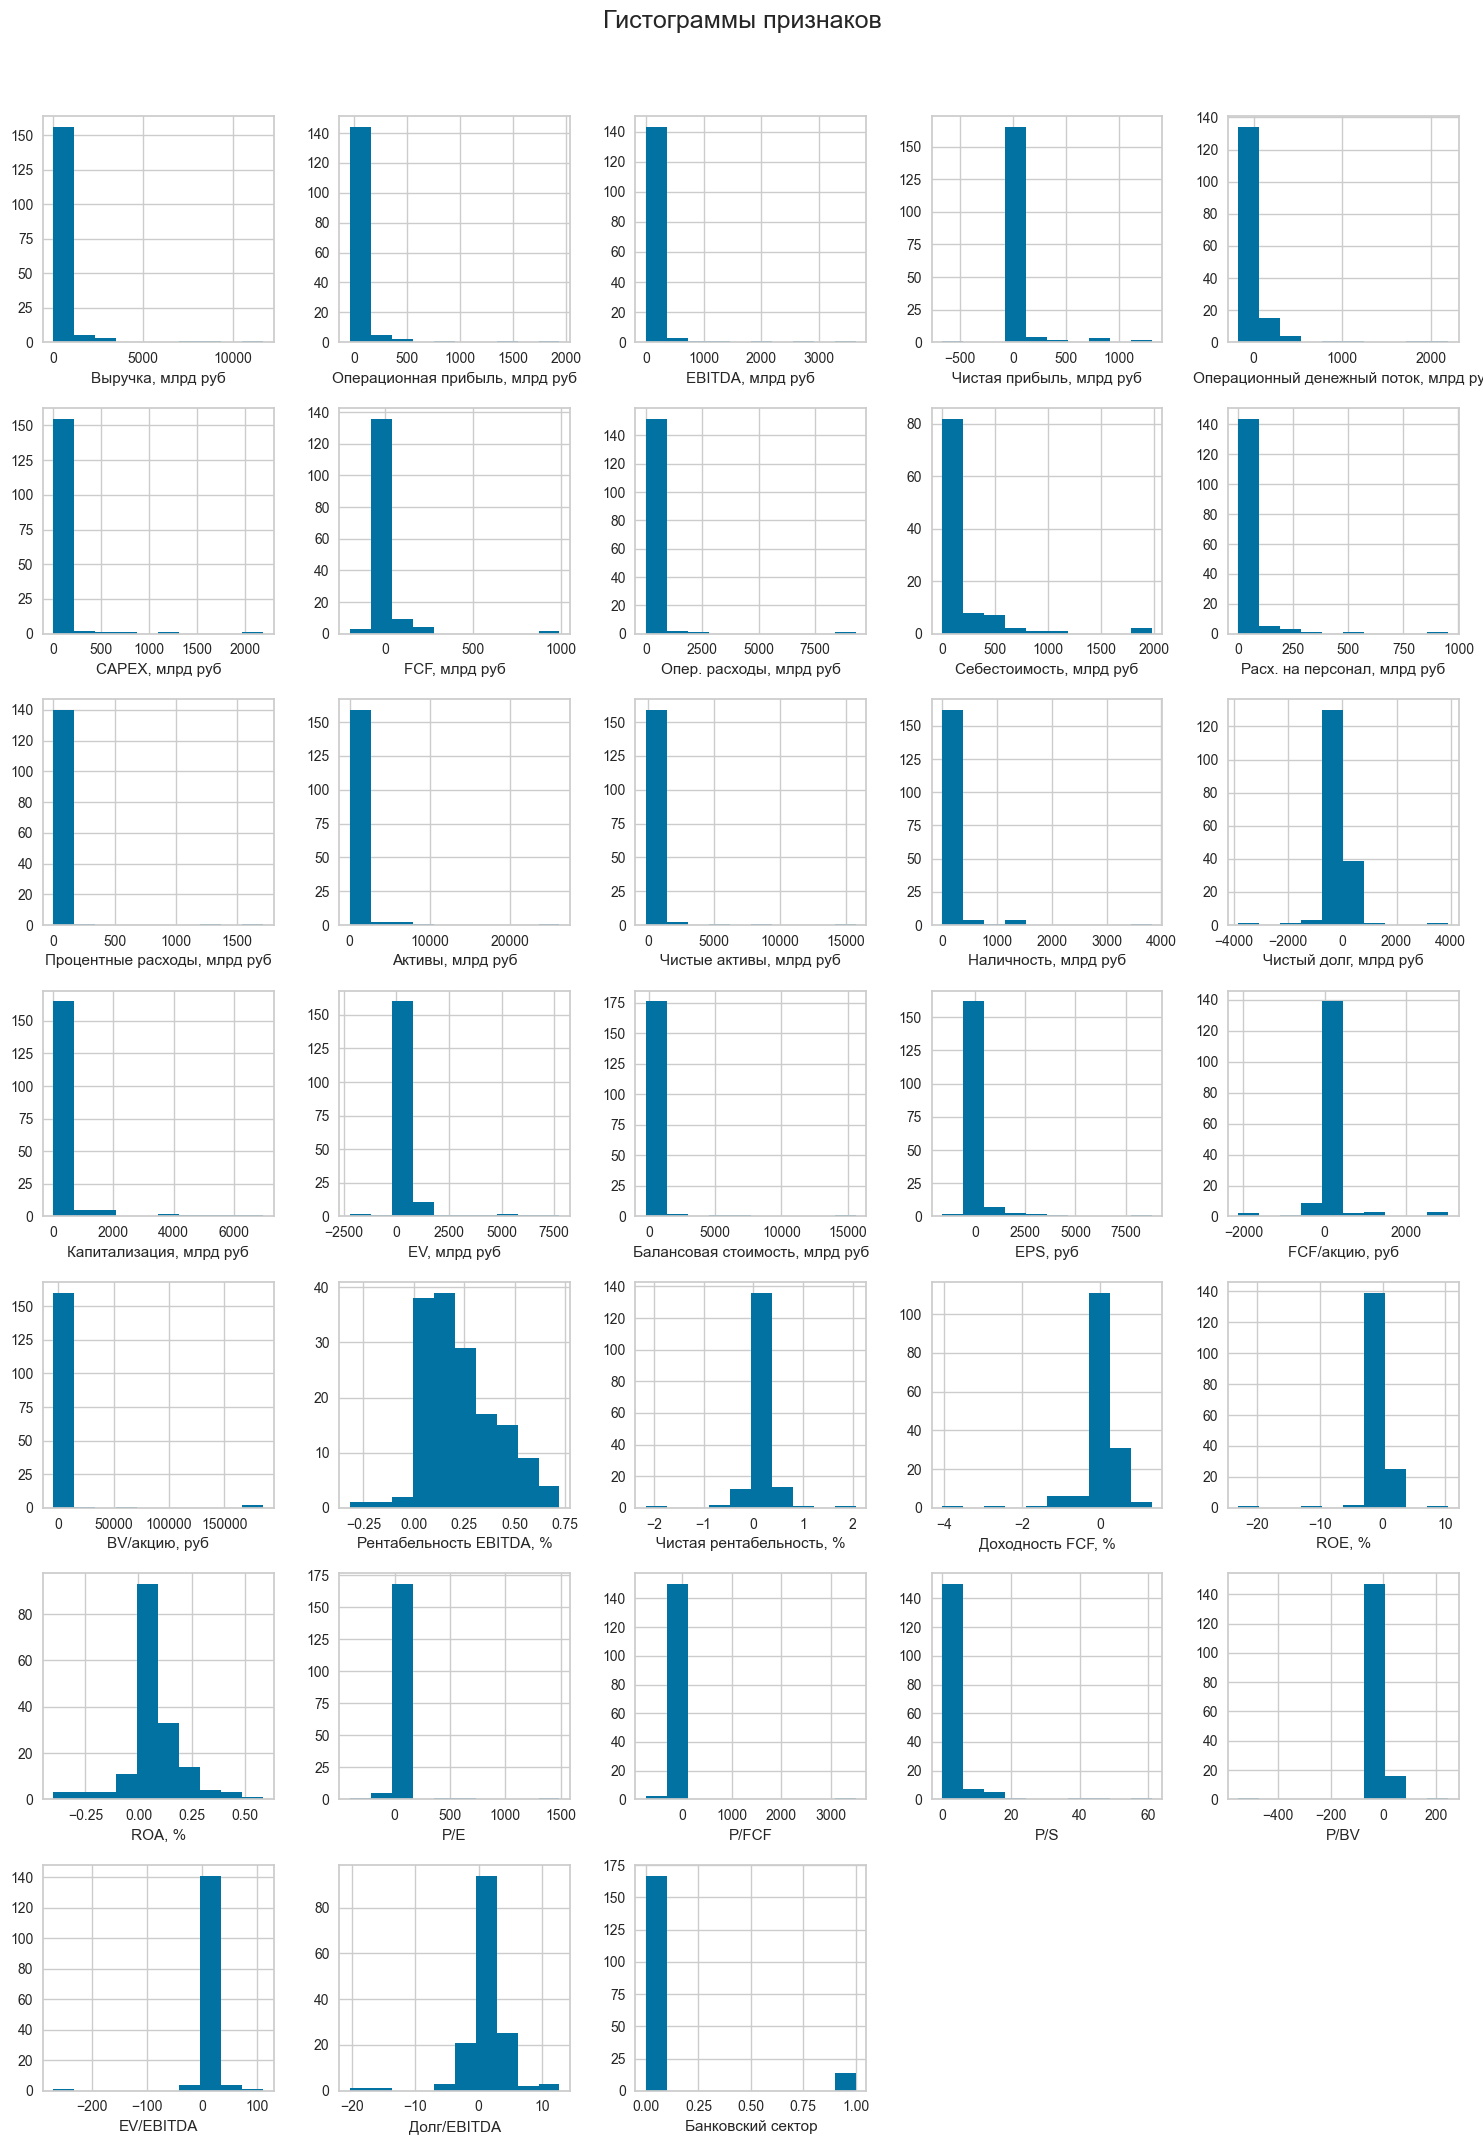

In [8]:
plots = df_new.shape[1]
cols = 5
rows = (plots + cols - 1) // cols 
f = plt.figure(figsize=(15, 3*rows))
for i in range(plots):
    plt.subplot(rows, cols, i+1)
    plt.hist(df_new.iloc[:, i])
    plt.xlabel(df_new.columns[i])

f.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle('Гистограммы признаков', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

1) Наиболее вероятное значение для каждого признака - 0
2) Визуально можно отметить, что распределение признака **Долг/EBITDA** приближенно к распределение Стьюдента
3) Распределение признаков **Себестоимость, млрд руб; Операционный денежный поток, млрд руб** похоже на Хи-квадрат распределение с одной степенью свободы
2) Распределение признаков **Рентабельность EBITDA, %; ROA, %** приближенно к логнормальному распределению
4) Остальные признаки лишь отдаленно напоминают распределение Стьюдента или Хи-квадрат 

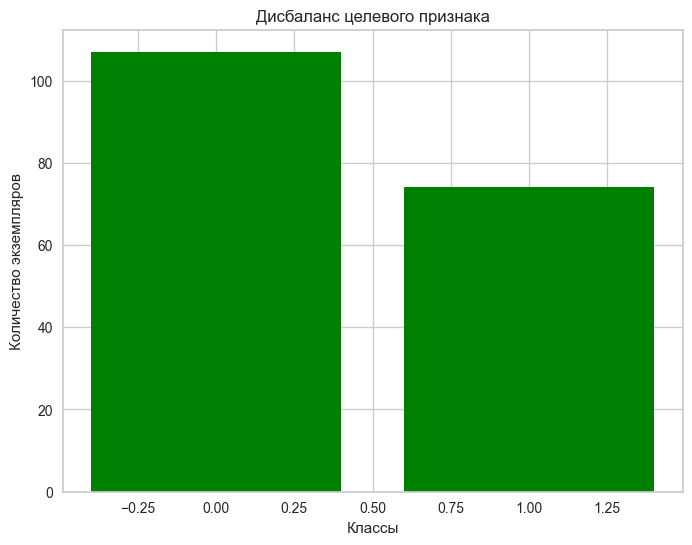

In [9]:
plt.figure(figsize=(8, 6))
plt.bar(df['Наличие ДД'].value_counts().index, df['Наличие ДД'].value_counts().values, color='green')
plt.xlabel('Классы')
plt.ylabel('Количество экземпляров')
plt.title('Дисбаланс целевого признака')
plt.show()

Визуально можно заметить небольшой дисбаланс классов в целевом признаке

## 2.3. Выявление аномальных значений

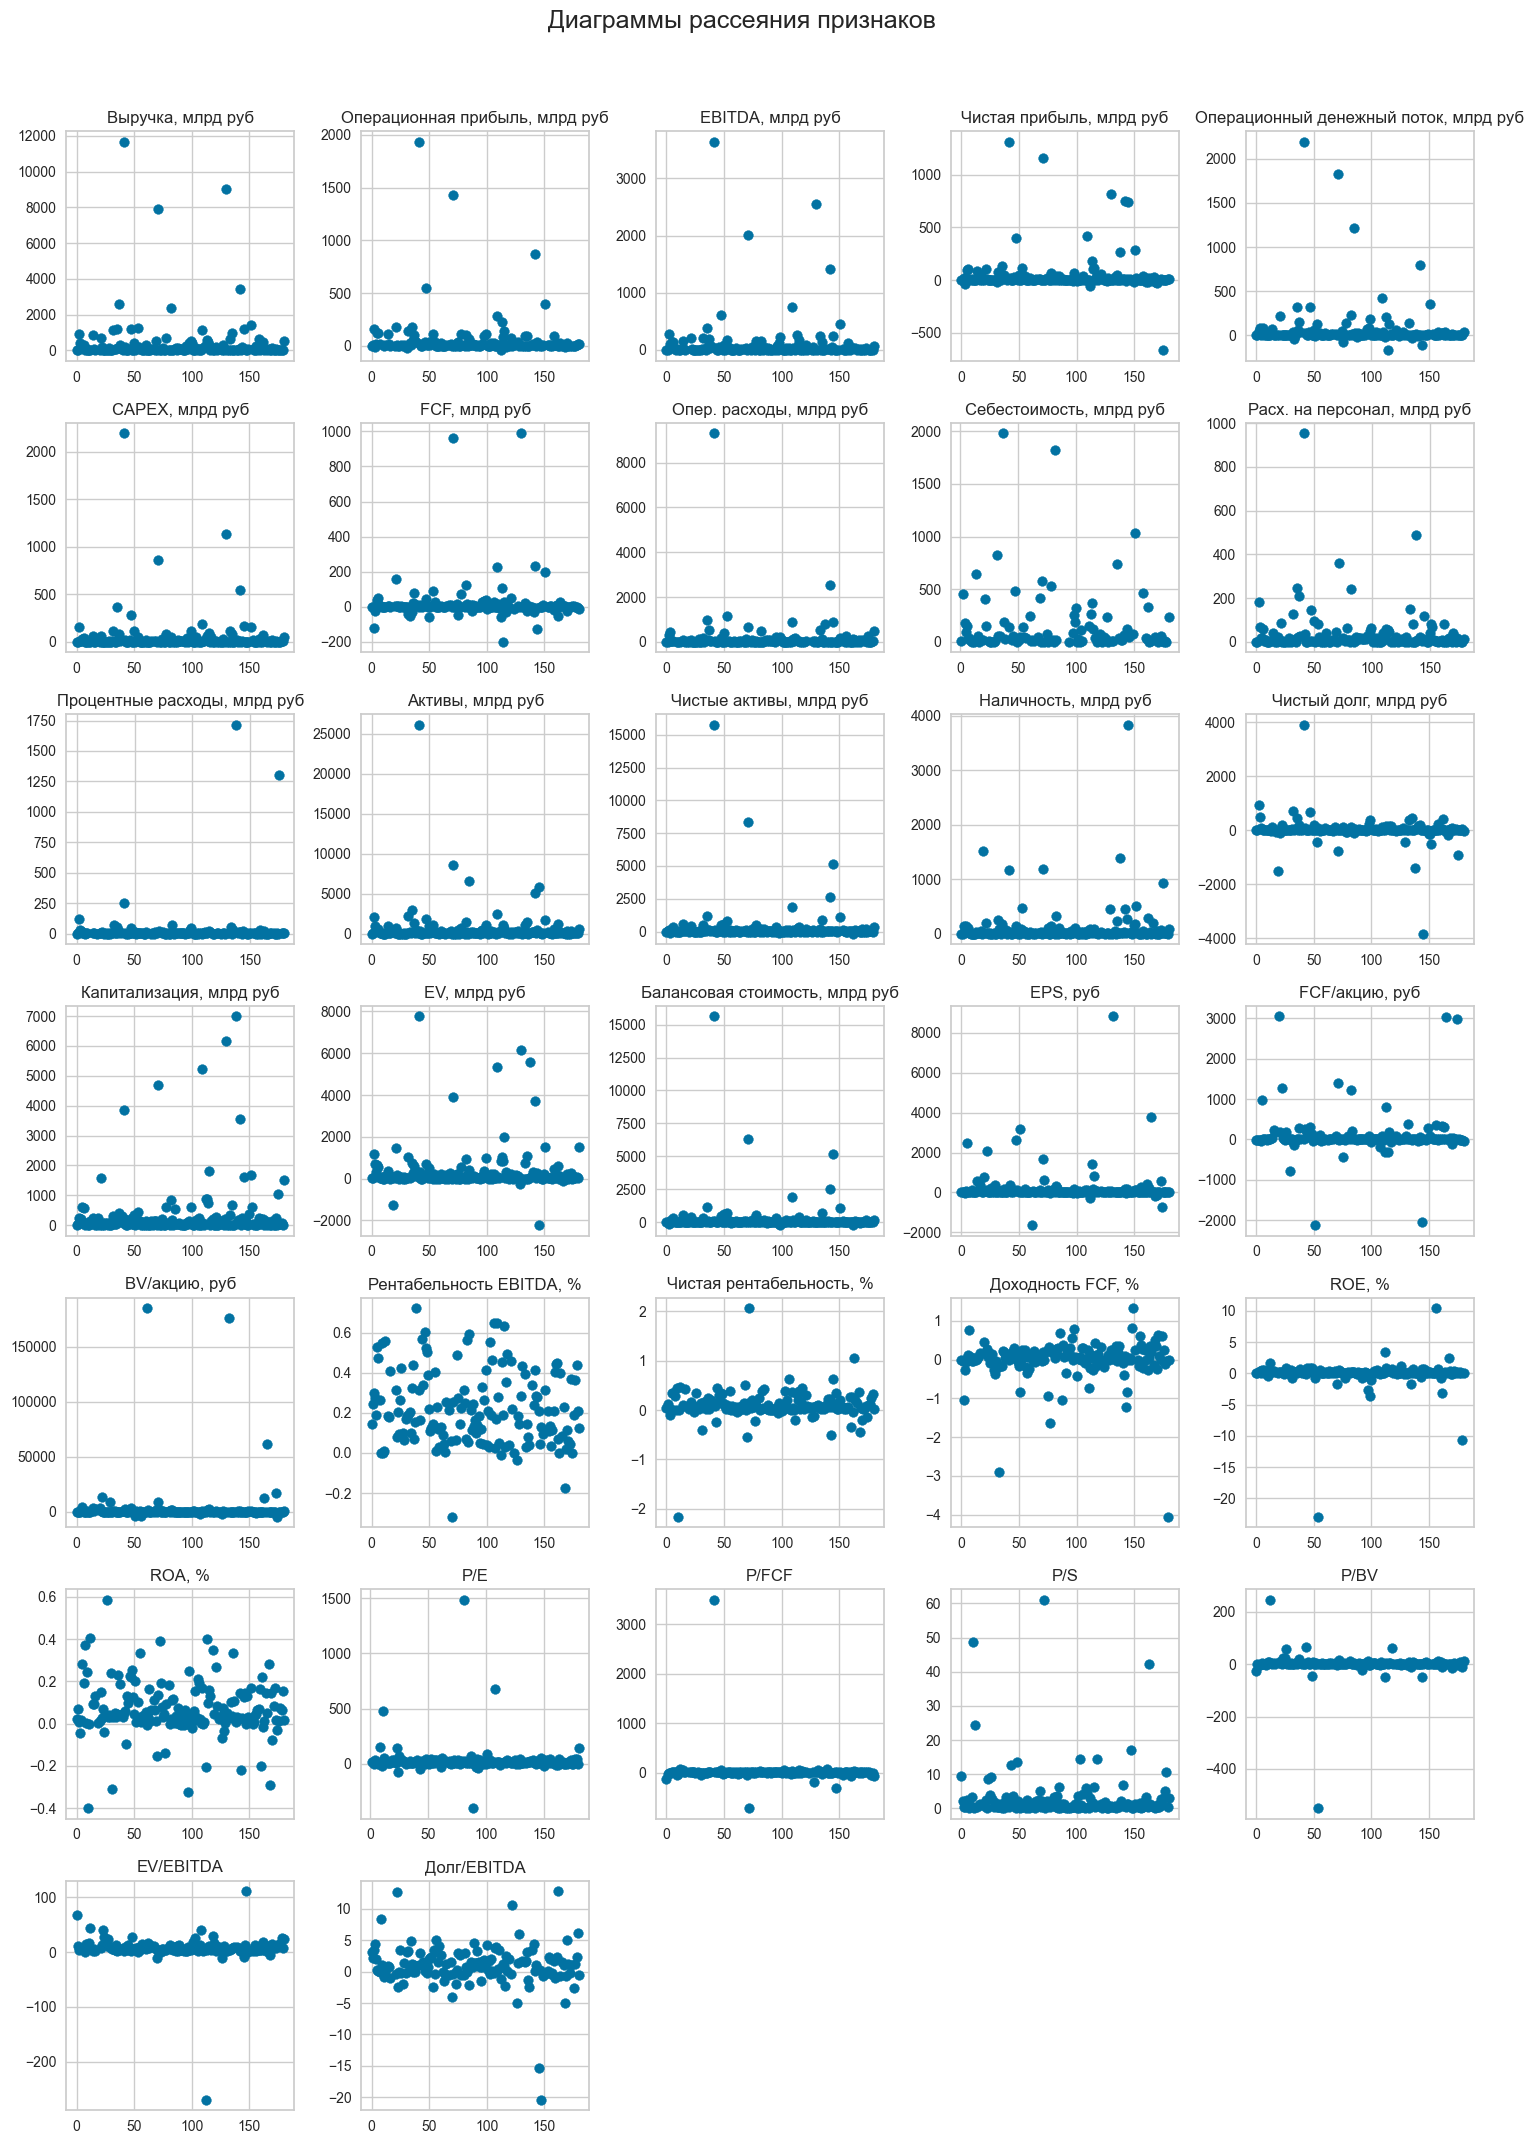

In [10]:
plots = df_new.shape[1]
cols = 5
rows = (plots + cols - 1) // cols 
f = plt.figure(figsize=(15, 3*rows))
for i in range(plots-1):
    plt.subplot(rows, cols, i+1)
    plt.scatter(np.arange(0, df_new.shape[0]), np.array(df_new[df_new.columns[i]].values))
    plt.title(df_new.columns[i])

f.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle('Диаграммы рассеяния признаков', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

Для некоторых признаков наблюдается системность в выбросах. Вероятно, большинство аномальных значений составляют крупнейшие компании

Посчитаю количество аномальных значений для каждой строки данных

In [11]:
df_anomal = df.copy()
lower_quantile = 0.05
upper_quantile = 0.95

df_anomal['Кол-во аномалий'] = 0

for column in df_anomal.columns:
    if pd.api.types.is_numeric_dtype(df_anomal[column]):
        lower_threshold = df_anomal[column].quantile(lower_quantile)
        upper_threshold = df_anomal[column].quantile(upper_quantile)
        
        anomalies = (df_anomal[column] < lower_threshold) | (df_anomal[column] > upper_threshold)
        
        df_anomal['Кол-во аномалий'] += anomalies

print('Топ 20 эмитентов по аномальным значениям')
df_anomal.sort_values('Кол-во аномалий', ascending=False).head(20)

Топ 20 эмитентов по аномальным значениям


,№,Эмитент,Тикер,Наличие ДД,"Выручка, млрд руб","Операционная прибыль, млрд руб","EBITDA, млрд руб","Чистая прибыль, млрд руб","Операционный денежный поток, млрд руб","CAPEX, млрд руб",...,"ROE, %","ROA, %",P/E,P/FCF,P/S,P/BV,EV/EBITDA,Долг/EBITDA,Банковский сектор,Кол-во аномалий
71,72,Лукойл,LKOH,1,7928.000,1428.00,2005.000,1155.000,1824.000,860.000,...,0.181,0.134,4.06,4.86,0.59,0.74,1.95,-0.39,0,20
41,42,Газпром,GAZP,1,11674.000,1935.20,3638.000,1312.000,2193.000,2192.000,...,0.083,0.050,2.94,3503.00,0.33,0.25,2.13,1.07,0,18
70,71,Фармсинтез,LIFE,0,0.380,-0.17,-0.121,-0.207,-0.003,0.003,...,-1.711,-0.154,-3.71,-43.90,2.02,-2.80,-10.40,-4.06,0,16
112,113,OZON | ОЗОН,OZON,0,277.100,-44.15,-3.220,-58.200,-18.800,35.600,...,3.495,-0.204,-14.90,-4.72,3.12,-49.90,-269.40,-1.13,0,15
142,143,Газпромнефть,SIBN,1,3412.000,870.40,1416.000,751.500,793.200,549.700,...,0.287,0.147,4.72,9.30,1.04,1.42,2.64,0.13,0,15
109,110,НОВАТЭК,NVTK,1,1157.000,279.00,748.300,421.300,419.500,191.300,...,0.222,0.171,12.40,22.90,4.51,2.76,7.16,0.18,0,14
145,146,Сургутнефтегаз,SNGS,1,1182.000,NaN,249.000,743.000,NaN,171.000,...,0.144,0.126,2.16,NaN,1.36,0.31,-8.92,-15.40,0,14
168,169,ОВК,UWGN,0,41.900,-11.40,-7.400,-18.800,5.000,0.370,...,0.445,-0.289,-0.32,1.97,0.14,-0.14,-5.86,-5.04,0,13
44,45,ММЦБ,GEMA,1,0.255,0.14,0.145,0.113,0.245,0.004,...,0.813,0.130,2.66,4.91,1.19,6.19,3.12,1.03,0,11
35,36,ФСК Россети,FEES,0,1182.000,182.00,384.200,132.800,322.200,362.800,...,0.111,0.045,1.98,-5.80,0.22,0.22,1.91,1.22,0,11


В данном топе большинство компаний являются крупными. Это подтверждает гипотезу, что у гегемонов рынка многие показатели сильно отличаются, от показателей других компаний

In [12]:
df_anomal.sort_values('Кол-во аномалий', ascending=False).head(20)['Наличие ДД'].value_counts()

Наличие ДД
1    12
0     8
Name: count, dtype: int64

Большинство компаний с аномальными значениями платит дивиденды

Вывод: аномальные значения в данном датасете удалять не стоит, т.к. это приведет к потере информации о ключевых для рынка компаниях, также удаление еще больше увеличит дисбаланс классов

## 2.4. Корреляционный анализ и понижение размерности

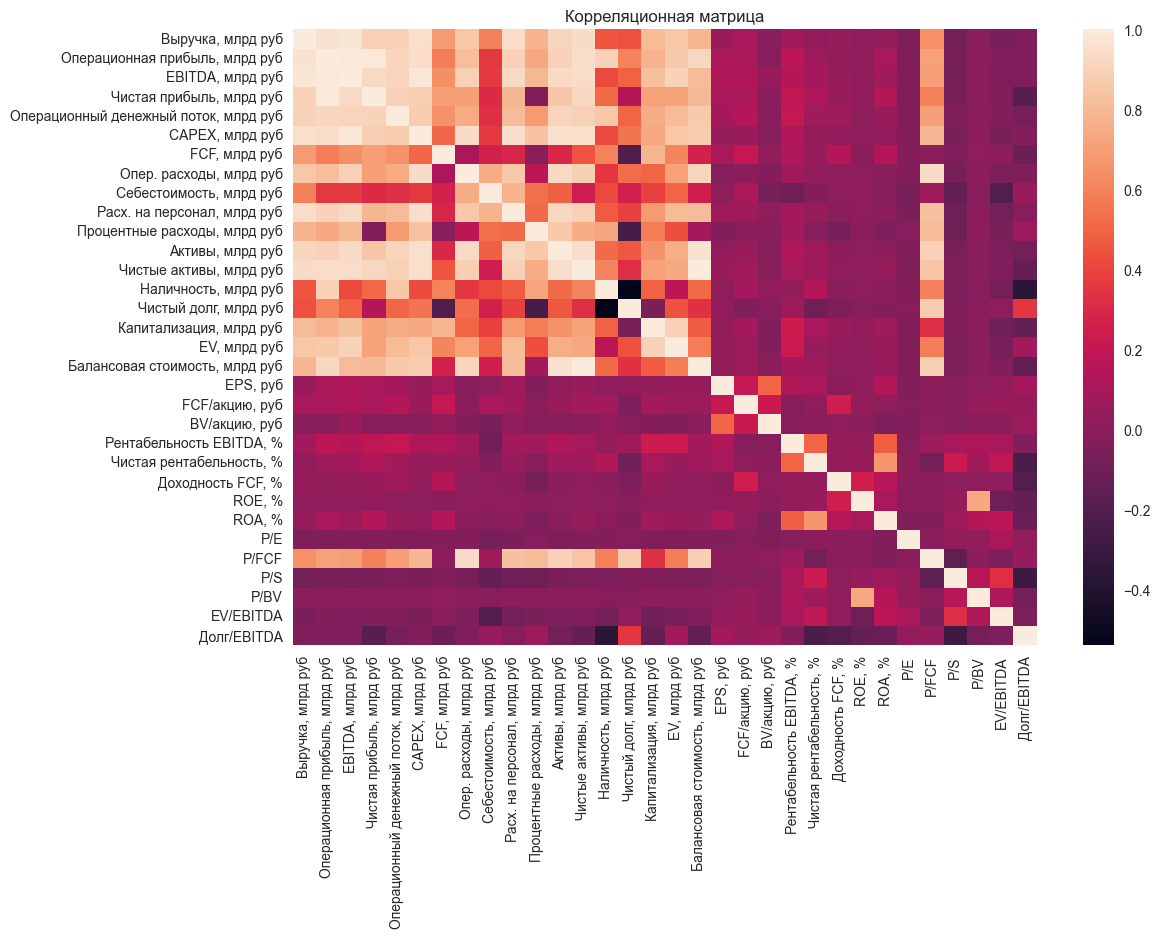

In [13]:
corr_df = df_new.drop(['Банковский сектор'], axis=1)
fig, ax = plt.subplots(figsize=(12, 8))
plt.title('Корреляционная матрица')
sns.heatmap(corr_df.corr());

Визуально наблюдается большое количество сильно коррелирующих признаков

In [14]:
# Выявление коррелированных признаков, которые коррелируют друг с другом больше, чем на 0.85
def get_correlated_features(corr_matrix, feat_stats=None, corr_threshold=0.9):
    correlated_features = set()
    
    for col in tqdm.tqdm(corr_matrix.columns, desc='Выявление коррелированных признаков'):
        correlated_cols = corr_matrix.index[np.abs(corr_matrix[col]) >= corr_threshold].tolist()
        
        if len(correlated_cols) > 1:
            correlated_cols.remove(col)
            print(f'{col} -> {correlated_cols}')
            print('_____________________________')
            correlated_features.update(correlated_cols[1:])
    
    return list(correlated_features)

In [15]:
# учту выводы из пункта 1.3
corr_df_without_1_3 = corr_df.drop(['Чистая прибыль, млрд руб', 'FCF, млрд руб', 'Процентные расходы, млрд руб',
                                   'Чистый долг, млрд руб', 'Балансовая стоимость, млрд руб', 'FCF/акцию, руб',
                                   'Доходность FCF, %', 'Долг/EBITDA'], axis=1)
corr_features = get_correlated_features(corr_df_without_1_3.corr(), corr_threshold=0.85)
print(f'Коррелированные признаки \n{corr_features}')

Выявление коррелированных признаков: 100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 4137.07it/s]

Выручка, млрд руб -> ['Операционная прибыль, млрд руб', 'EBITDA, млрд руб', 'Операционный денежный поток, млрд руб', 'CAPEX, млрд руб', 'Опер. расходы, млрд руб', 'Расх. на персонал, млрд руб', 'Активы, млрд руб', 'Чистые активы, млрд руб', 'EV, млрд руб']
_____________________________
Операционная прибыль, млрд руб -> ['Выручка, млрд руб', 'EBITDA, млрд руб', 'Операционный денежный поток, млрд руб', 'CAPEX, млрд руб', 'Расх. на персонал, млрд руб', 'Активы, млрд руб', 'Чистые активы, млрд руб', 'Наличность, млрд руб', 'EV, млрд руб']
_____________________________
EBITDA, млрд руб -> ['Выручка, млрд руб', 'Операционная прибыль, млрд руб', 'Операционный денежный поток, млрд руб', 'CAPEX, млрд руб', 'Опер. расходы, млрд руб', 'Расх. на персонал, млрд руб', 'Активы, млрд руб', 'Чистые активы, млрд руб', 'EV, млрд руб']
_____________________________
Операционный денежный поток, млрд руб -> ['Выручка, млрд руб', 'Операционная прибыль, млрд руб', 'EBITDA, млрд руб', 'CAPEX, млрд руб', 'Актив

Удалю сильно коррелированные признаки, тем самым понижу размерность датафрейма

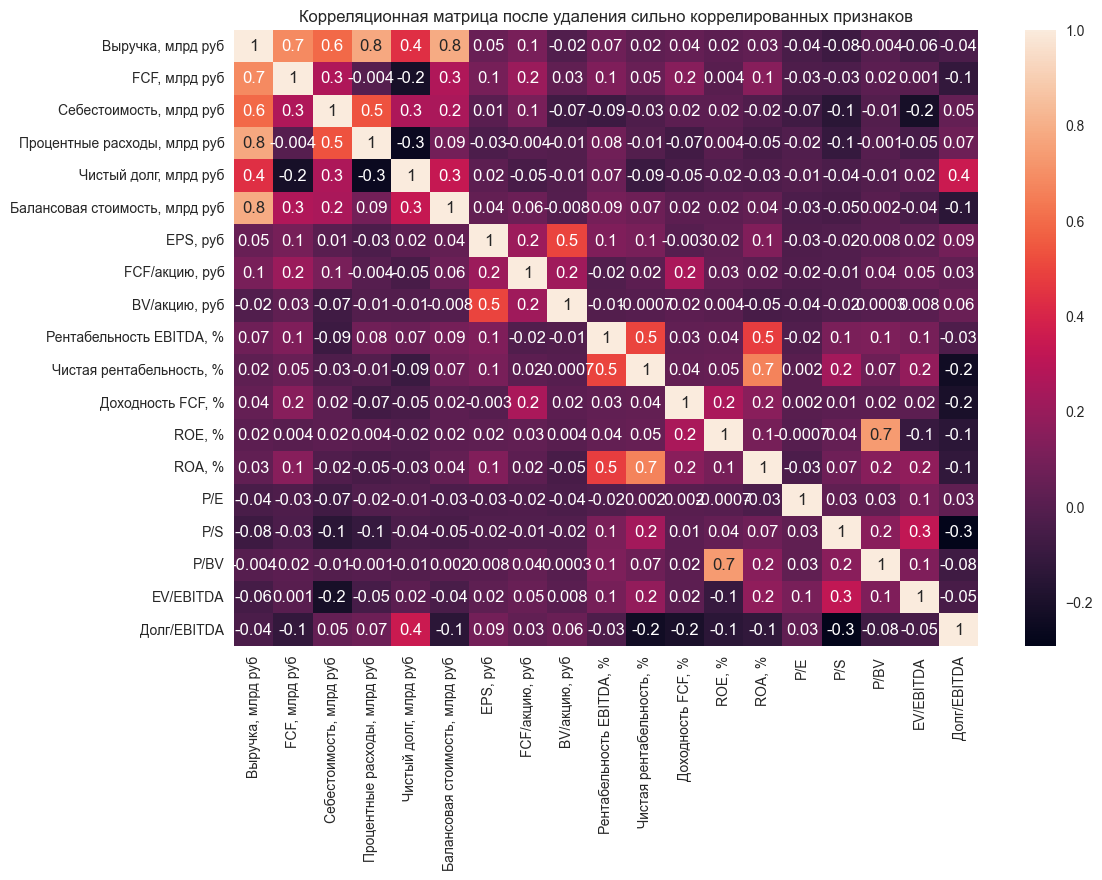

In [19]:
corr_df = df_new.drop(corr_features+['Банковский сектор', 'Чистая прибыль, млрд руб'], axis=1)
fig, ax = plt.subplots(figsize=(12, 8))
plt.title('Корреляционная матрица после удаления сильно коррелированных признаков')
sns.heatmap(corr_df.corr(), annot=True, fmt='.1g');

Также удалю столбец **Выручка, млрд руб**, т.к он сильно коррелирует со столбцом **Чистая прибыль, млрд руб** и менее значим

In [18]:
X = df_new.drop(corr_features+['Выручка, млрд руб'], axis=1)
y = df['Наличие ДД']
print('Датафрейм после проведения корреляционного анализа и понижения размерности')
X.head()

Датафрейм после проведения корреляционного анализа и понижения размерности


,"Чистая прибыль, млрд руб","FCF, млрд руб","Себестоимость, млрд руб","Процентные расходы, млрд руб","Чистый долг, млрд руб","Балансовая стоимость, млрд руб","EPS, руб","FCF/акцию, руб","BV/акцию, руб","Рентабельность EBITDA, %","Чистая рентабельность, %","Доходность FCF, %","ROE, %","ROA, %",P/E,P/S,P/BV,EV/EBITDA,Долг/EBITDA,Банковский сектор
0,0.046,-0.042,NaN,0.055,0.51,-0.4,0.50,-0.45,-4.26,0.144,0.040,-0.007,0.135,0.023,NaN,9.37,-27.00,68.00,3.09,0
1,1.750,-0.672,6.33,0.627,7.13,12.6,17.90,-6.86,128.20,0.245,0.127,-0.036,0.139,0.071,16.80,2.13,2.33,10.80,2.11,0
2,19.400,-119.300,454.60,115.800,926.70,-154.1,2.01,-12.40,-16.00,0.298,0.021,-1.042,0.185,0.009,12.70,0.27,-1.60,4.32,3.41,0
3,-41.400,-24.900,NaN,31.800,503.60,-93.9,-10.40,-6.26,-23.60,0.273,-0.100,-0.255,0.453,-0.043,-4.99,0.50,-2.20,6.29,4.46,0
4,6.800,-4.600,184.40,20.800,91.20,151.1,50.50,-34.20,1123.00,0.187,0.028,-0.052,0.044,0.017,31.00,0.88,1.40,6.72,2.03,0


In [19]:
X.shape

(181, 20)

# 3. Разработка модели машинного обучения

##### Признак - Банковский сектор

In [20]:
df[df['Банковский сектор']==1].head()

,№,Эмитент,Тикер,Наличие ДД,"Выручка, млрд руб","Операционная прибыль, млрд руб","EBITDA, млрд руб","Чистая прибыль, млрд руб","Операционный денежный поток, млрд руб","CAPEX, млрд руб",...,"Доходность FCF, %","ROE, %","ROA, %",P/E,P/FCF,P/S,P/BV,EV/EBITDA,Долг/EBITDA,Банковский сектор
13,14,Авангард,AVAN,1,NaN,NaN,NaN,3.12,NaN,NaN,...,0.0,NaN,NaN,26.80,NaN,NaN,3.34,NaN,NaN,1
17,18,Банк Санкт-Петербург,BSPB,1,NaN,NaN,NaN,47.50,NaN,NaN,...,NaN,NaN,NaN,3.26,NaN,NaN,NaN,NaN,NaN,1
18,19,КарМани (СТГ),CARM,0,NaN,NaN,NaN,0.39,0.087,NaN,...,NaN,NaN,NaN,12.20,NaN,NaN,NaN,NaN,NaN,1
19,20,МКБ,CBOM,0,NaN,NaN,NaN,7.47,NaN,NaN,...,NaN,0.037,0.002,33.50,NaN,NaN,NaN,NaN,NaN,1
66,67,Кузнецкий банк,KUZB,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


В признаках компаний из банковского сектора слишком много пропущенных значений, они не информативны

Для построения модели буду использовать только данные компаний не из банковского сектора

In [21]:
X = X[X['Банковский сектор'] == 0]
X.drop('Банковский сектор', axis=1, inplace=True)
X.head()

,"Чистая прибыль, млрд руб","FCF, млрд руб","Себестоимость, млрд руб","Процентные расходы, млрд руб","Чистый долг, млрд руб","Балансовая стоимость, млрд руб","EPS, руб","FCF/акцию, руб","BV/акцию, руб","Рентабельность EBITDA, %","Чистая рентабельность, %","Доходность FCF, %","ROE, %","ROA, %",P/E,P/S,P/BV,EV/EBITDA,Долг/EBITDA
0,0.046,-0.042,NaN,0.055,0.51,-0.4,0.50,-0.45,-4.26,0.144,0.040,-0.007,0.135,0.023,NaN,9.37,-27.00,68.00,3.09
1,1.750,-0.672,6.33,0.627,7.13,12.6,17.90,-6.86,128.20,0.245,0.127,-0.036,0.139,0.071,16.80,2.13,2.33,10.80,2.11
2,19.400,-119.300,454.60,115.800,926.70,-154.1,2.01,-12.40,-16.00,0.298,0.021,-1.042,0.185,0.009,12.70,0.27,-1.60,4.32,3.41
3,-41.400,-24.900,NaN,31.800,503.60,-93.9,-10.40,-6.26,-23.60,0.273,-0.100,-0.255,0.453,-0.043,-4.99,0.50,-2.20,6.29,4.46
4,6.800,-4.600,184.40,20.800,91.20,151.1,50.50,-34.20,1123.00,0.187,0.028,-0.052,0.044,0.017,31.00,0.88,1.40,6.72,2.03


##### Работа с пропуенными значениями

In [22]:
# Количество строк с пропущенными значениями
(X.isna().sum(axis=1) != 0).sum()

93

При удалении строк с пропущенными значениями останется мало данных

Заменю пропущенные значения на 0, т.к это будет наиболее точно отражать финансовые отчеты компаний:
1) Если брать случайные значения из распределения или медиану, то у компаний в зависимости от количества данных в датасете будут меняться показатели, и, следовательно, будет меняться прогноз
2) При работе с новыми данными, где также будут пропущенные значения, замену (отличную от 0), выполненную в модели, будет повторить проблематично
3) В некоторых отчетах не заполняют данные, в которых подразумевают 0

In [23]:
X = X.fillna(0)

##### Нормализация данных

Нормализую данные с помощью минимально-максимальной нормализации

In [24]:
scaler = MinMaxScaler()
X_n = scaler.fit(X).transform(X)
X_n = pd.DataFrame(X_n, columns=X.columns)
X_n.head()

,"Чистая прибыль, млрд руб","FCF, млрд руб","Себестоимость, млрд руб","Процентные расходы, млрд руб","Чистый долг, млрд руб","Балансовая стоимость, млрд руб","EPS, руб","FCF/акцию, руб","BV/акцию, руб","Рентабельность EBITDA, %","Чистая рентабельность, %","Доходность FCF, %","ROE, %","ROA, %",P/E,P/S,P/BV,EV/EBITDA,Долг/EBITDA
0,0.042509,0.168872,0.000000,0.000217,0.494961,0.013921,0.156830,0.410392,0.023994,0.443804,0.520730,0.751160,0.690991,0.428571,0.213822,0.153355,0.656176,0.886961,0.707530
1,0.043753,0.168343,0.003199,0.002477,0.495816,0.014741,0.158494,0.409153,0.024692,0.540826,0.541341,0.745778,0.691111,0.477204,0.222698,0.034861,0.692953,0.736593,0.678012
2,0.056634,0.068655,0.229712,0.457527,0.614670,0.004217,0.156974,0.408082,0.023932,0.591739,0.516228,0.559102,0.692487,0.414387,0.220532,0.004419,0.688025,0.719558,0.717169
3,0.012261,0.147983,0.000000,0.125642,0.559984,0.008018,0.155787,0.409269,0.023892,0.567723,0.487562,0.705140,0.700506,0.361702,0.211185,0.008183,0.687273,0.724737,0.748795
4,0.047438,0.165042,0.093178,0.082181,0.506682,0.023485,0.161613,0.403867,0.029937,0.485110,0.517887,0.742809,0.688269,0.422492,0.230200,0.014403,0.691787,0.725868,0.675602


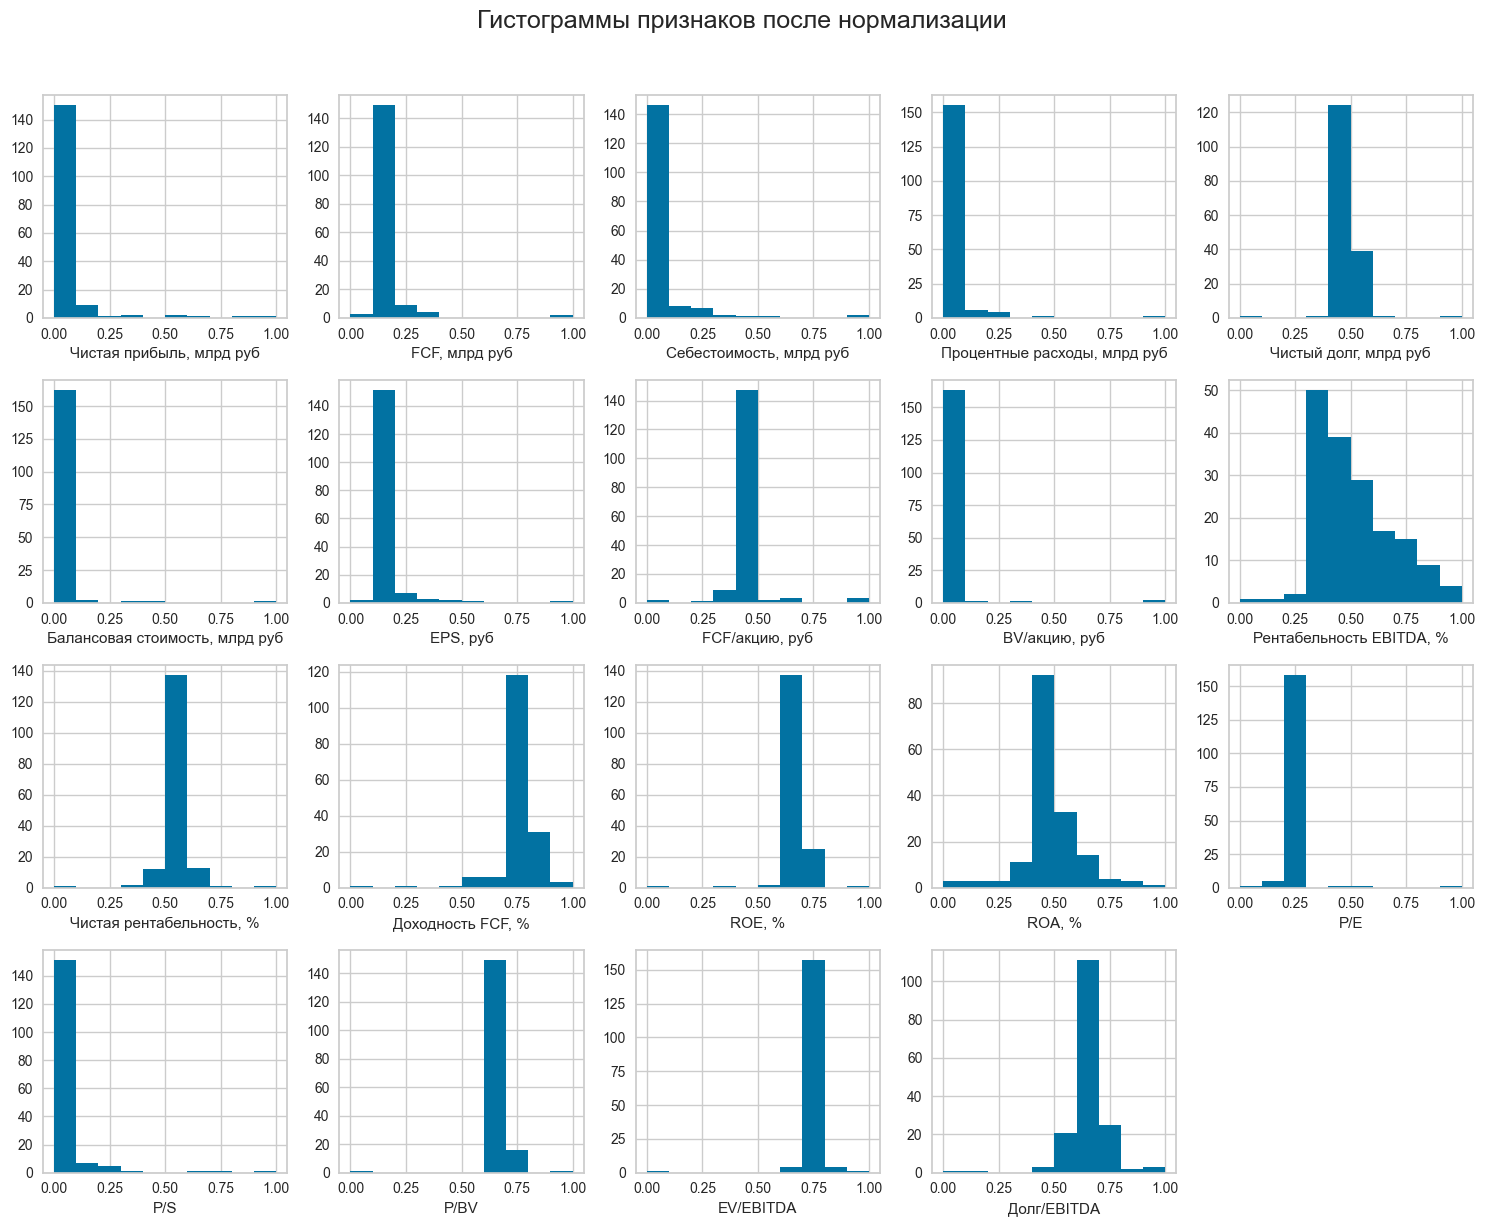

In [25]:
plots = X_n.shape[1]
cols = 5
rows = (plots + cols - 1) // cols 
f = plt.figure(figsize=(15, 3*rows))
for i in range(plots):
    plt.subplot(rows, cols, i+1)
    plt.hist(X_n.fillna(0).iloc[:, i])
    plt.xlabel(X_n.fillna(0).columns[i])

f.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle('Гистограммы признаков после нормализации', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

## 3.1. Разделение выборки на обучающую и тестовую.

Разделение выборки будет случайным

Воспользуюсь стратификацией, чтобы сохранить соотношение классов

In [26]:
X = X_n.copy()
y = df[df['Банковский сектор'] == 0]['Наличие ДД']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)

## 3.2. Обучение моделей

### 3.2.1 Обоснование выбранных метрик для оценки качества моделей

Как ключевую метрику для оценки качества моделей выберу **ROC-AUC Score** - площадь под ROC-кривой. Т.к. она показывает общее качество модели вне зависимости от выбора порога принадлежности к классам. Также данная метрика дает объективную оценку при дисбалансе классов. Кроме того, с помощью ROC-кривой можно подобрать оптимальный порог классификации. 

Также буду использовать метрики: f1-score, recall и precison

### 3.2.2. Обучение нескольких моделей для решения задачи 

In [27]:
def train_metric_time_model(model, X_train, X_test, y_train, y_test, name, cv=5):
    start_time = time.time()
    if name == 'LightGBM':
        model.fit(pd.DataFrame(X_train.values), y_train)
    else:
        model.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    cv_results = cross_val_score(model, pd.DataFrame(X.values), y, cv=cv, scoring='roc_auc')
    cv_mean = cv_results.mean()
    cv_std = cv_results.std()
    
    return {
        'cv_ROC_AUC': cv_mean,
        'F1_score': f1, 
        'Recall': recall, 
        'Precision': precision, 
        'Train_time': train_time,
    }

In [49]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'MLPClassifier': MLPClassifier(random_state=42),
    'LightGBM': LGBMClassifier(max_depth=2, random_state=42, verbosity=-1),
    'XGBoost': XGBClassifier(max_depth=2, random_state=42, verbose=0),
    'CatBoost': CatBoostClassifier(max_depth=2, random_state=42, verbose=0)
}

results = {}

kf = KFold(n_splits = 5,shuffle=True, random_state=2)

for name, model in models.items():
    print(f'Модель: {name}')
    result = train_metric_time_model(model, X_train, X_test, y_train, y_test, name, kf)
    results[name] = result
    print(f'Время обучения: {result["Train_time"]:.2f}')
    print(f'ROC AUC: {result["cv_ROC_AUC"]:.4f}, F1-score: {result["F1_score"]:.4f}, Recall: {result["Recall"]:.4f}, Precision: {result["Precision"]:.4f}\n')

print('Результаты:')
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.sort_values('cv_ROC_AUC', ascending=False)

Модель: Logistic Regression
Время обучения: 0.01
ROC AUC: 0.6577, F1-score: 0.0000, Recall: 0.0000, Precision: 0.0000

Модель: KNN
Время обучения: 0.00
ROC AUC: 0.6990, F1-score: 0.5714, Recall: 0.5714, Precision: 0.5714

Модель: Naive Bayes
Время обучения: 0.00
ROC AUC: 0.6925, F1-score: 0.7059, Recall: 0.8571, Precision: 0.6000

Модель: Decision Tree
Время обучения: 0.00
ROC AUC: 0.5551, F1-score: 0.4000, Recall: 0.3571, Precision: 0.4545

Модель: Random Forest
Время обучения: 0.15
ROC AUC: 0.7086, F1-score: 0.5000, Recall: 0.4286, Precision: 0.6000

Модель: SVM
Время обучения: 0.00
ROC AUC: 0.6048, F1-score: 0.0000, Recall: 0.0000, Precision: 0.0000

Модель: MLPClassifier
Время обучения: 0.19
ROC AUC: 0.6506, F1-score: 0.0000, Recall: 0.0000, Precision: 0.0000

Модель: LightGBM
Время обучения: 0.02
ROC AUC: 0.7100, F1-score: 0.5000, Recall: 0.4286, Precision: 0.6000

Модель: XGBoost
Время обучения: 0.10
ROC AUC: 0.7374, F1-score: 0.5385, Recall: 0.5000, Precision: 0.5833

Модель: Ca

,cv_ROC_AUC,F1_score,Recall,Precision,Train_time
XGBoost,0.737380,0.538462,0.500000,0.583333,0.095515
CatBoost,0.728560,0.454545,0.357143,0.625000,1.280676
LightGBM,0.710014,0.500000,0.428571,0.600000,0.020423
Random Forest,0.708551,0.500000,0.428571,0.600000,0.146613
KNN,0.699029,0.571429,0.571429,0.571429,0.000000
Naive Bayes,0.692469,0.705882,0.857143,0.600000,0.003008
Logistic Regression,0.657723,0.000000,0.000000,0.000000,0.008348
MLPClassifier,0.650593,0.000000,0.000000,0.000000,0.187616
SVM,0.604849,0.000000,0.000000,0.000000,0.000000
Decision Tree,0.555146,0.400000,0.357143,0.454545,0.000000


In [28]:
best_model = XGBClassifier(max_depth=2, random_state=42).fit(X_train, y_train)
roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

0.6464285714285715

### 3.2.3. Анализ результатов по метрикам и по затраченному времени

Лучшая модель по ROC AUC Score - **XGBoost** с результатом 0.7374 и затраченным временем 0.05 сек

Лучшие модели по затраченному времени на обучение - **SVM**, **Decision Tree** и **Naive Bayes**, но по ключевой метрике отстают от XGBoost

## 3.3. Подбор и выбор гиперпараметров модели с помощью Grid Search

In [51]:
param_grid = {
    'max_depth': range (2, 6, 1),
    'n_estimators': range(70, 130, 10),
    'learning_rate': [0.1, 0.01, 0.05]
}

xgb_model = XGBClassifier(random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=kf, scoring='roc_auc', verbose=2)

grid_search.fit(X, y)

print("Наилучшие параметры:", grid_search.best_params_)
print("Наилучшая оценка (ROC AUC):", grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_

In [29]:
params = {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 120}

In [30]:
best_model = XGBClassifier(**params, random_state=42).fit(X_train,y_train)

In [31]:
roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

0.7392857142857143

После подбора гиперпараметров с помощью Grid Search ключевая метрика стала выше

## 3.4. Совершенствование модели

### Регуляризация

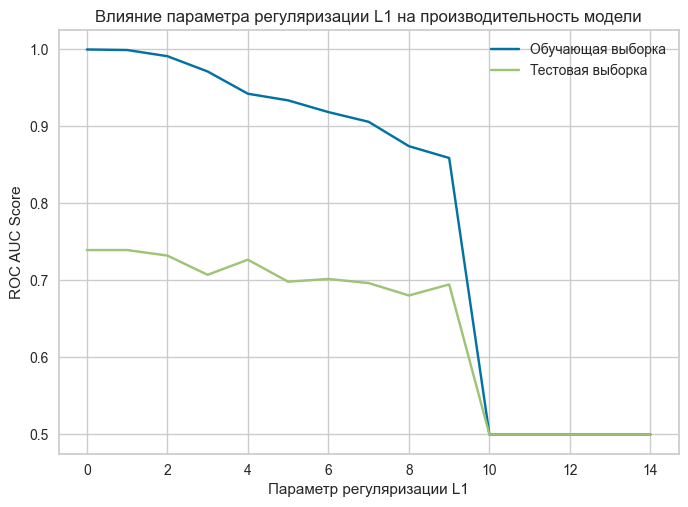

In [32]:
# Рассмотрение L1 регуляризации
trains = []
tests = []
for i in np.linspace(0, 15, 15):
    xgboost_model = XGBClassifier(**params, reg_alpha=i, random_state=42).fit(X_train,y_train)
    trains.append(roc_auc_score(y_train, xgboost_model.predict_proba(X_train)[:, 1]))
    tests.append(roc_auc_score(y_test, xgboost_model.predict_proba(X_test)[:, 1]))

plt.plot(trains, label="Обучающая выборка")
plt.plot(tests, label="Тестовая выборка")
plt.xlabel("Параметр регуляризации L1")
plt.ylabel("ROC AUC Score")
plt.title("Влияние параметра регуляризации L1 на производительность модели")
plt.legend()
plt.show()

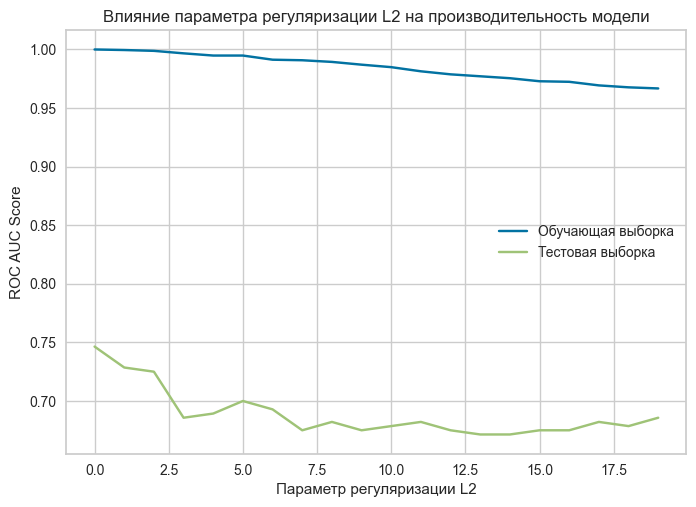

In [33]:
# Рассмотрение L2 регуляризации
trains = []
tests = []
for i in np.linspace(0, 20, 20):
    xgboost_model = XGBClassifier(**params, reg_lambda=i, random_state=42).fit(X_train,y_train)
    trains.append(roc_auc_score(y_train, xgboost_model.predict_proba(X_train)[:, 1]))
    tests.append(roc_auc_score(y_test, xgboost_model.predict_proba(X_test)[:, 1]))

plt.plot(trains, label="Обучающая выборка")
plt.plot(tests, label="Тестовая выборка")
plt.xlabel("Параметр регуляризации L2")
plt.ylabel("ROC AUC Score")
plt.title("Влияние параметра регуляризации L2 на производительность модели")
plt.legend()
plt.show()

In [34]:
best_model = XGBClassifier(**params, reg_lambda=0, random_state=42).fit(X_train,y_train)
roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

0.7464285714285714

При L2 = 0 модель предсказывает лучше

### Oversampling

Уравняю классы разными методами

In [35]:
def regularization_oversampling(X_train_, y_train_, X_test_, y_test_):
    trains = []
    tests = []
    for i in range(0, 41):
        xgboost_model = XGBClassifier(**params, reg_alpha=i, random_state=42).fit(X_train_,y_train_)
        trains.append(roc_auc_score(y_train_, xgboost_model.predict_proba(X_train_)[:, 1]))
        tests.append(roc_auc_score(y_test_, xgboost_model.predict_proba(X_test_)[:, 1]))
    print(f'Лучшая метрика {max(tests)} при L1 = {tests.index(max(tests))}')


    trains = []
    tests = []
    for i in range(0, 41):
        xgboost_model = XGBClassifier(**params, reg_lambda=i, random_state=42).fit(X_train_,y_train_)
        trains.append(roc_auc_score(y_train_, xgboost_model.predict_proba(X_train_)[:, 1]))
        tests.append(roc_auc_score(y_test_, xgboost_model.predict_proba(X_test_)[:, 1]))

    print(f'Лучшая метрика {max(tests)} при L2 = {tests.index(max(tests))}')

##### RandomOverSampler

In [36]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

In [37]:
regularization_oversampling(X_res, y_res, X_test, y_test)

Лучшая метрика 0.725 при L1 = 0
Лучшая метрика 0.7642857142857143 при L2 = 0


In [38]:
best_model_ros = XGBClassifier(**params, reg_lambda=0, random_state=42).fit(X_res,y_res)
roc_auc_score(y_test, best_model_ros.predict_proba(X_test)[:, 1])

0.7642857142857143

##### SMOTE

In [39]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [40]:
regularization_oversampling(X_res, y_res, X_test, y_test)

Лучшая метрика 0.8 при L1 = 0
Лучшая метрика 0.8 при L2 = 1


In [41]:
best_model_smote = XGBClassifier(**params, random_state=42).fit(X_res,y_res)
roc_auc_score(y_test, best_model_smote.predict_proba(X_test)[:, 1])

0.8

##### ADASYN

In [42]:
adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

In [43]:
regularization_oversampling(X_res, y_res, X_test, y_test)

Лучшая метрика 0.817857142857143 при L1 = 0
Лучшая метрика 0.8428571428571429 при L2 = 2


In [44]:
trains = []
tests = []
for i in range(0, 41):
    xgboost_model = XGBClassifier(**params, reg_alpha=i, reg_lambda=2, random_state=42).fit(X_res,y_res)
    trains.append(roc_auc_score(y_res, xgboost_model.predict_proba(X_res)[:, 1]))
    tests.append(roc_auc_score(y_test, xgboost_model.predict_proba(X_test)[:, 1]))
print(f'Лучшая метрика {max(tests)} при L2 = 2 и L2 = {tests.index(max(tests))}')

Лучшая метрика 0.8428571428571429 при L2 = 2 и L2 = 0


In [45]:
best_model_adasyn = XGBClassifier(**params, reg_lambda=2, random_state=42).fit(X_res,y_res)
roc_auc_score(y_test, best_model_adasyn.predict_proba(X_test)[:, 1])

0.8428571428571429

При использовании метода ADASYN получилось значительно улучшить модель

### Отбор признаков

In [46]:
def feature_importance_func(importance, names, model_name="", top_n=-1, skip_columns=[], plot=False):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    if plot:
        plt.figure(figsize=(12,10))
        sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
        if top_n != -1:
            plt.title(f"Важность признаков модели {model_name} (Топ: {top_n})")
        else:
            plt.title(f"Важность признаков модели {model_name}")
        plt.xlabel('Важность признаков')
        plt.ylabel('Названия признаков')
    
    lst_ = list(fi_df['feature_names'][:top_n])
    print(lst_)
    return lst_

['FCF, млрд руб', 'P/E', 'Себестоимость, млрд руб', 'EV/EBITDA', 'Доходность FCF, %', 'Чистый долг, млрд руб', 'FCF/акцию, руб', 'Балансовая стоимость, млрд руб', 'Чистая рентабельность, %', 'P/BV', 'Чистая прибыль, млрд руб', 'EPS, руб', 'P/S', 'ROE, %', 'ROA, %', 'Рентабельность EBITDA, %', 'Долг/EBITDA', 'Процентные расходы, млрд руб', 'BV/акцию, руб']


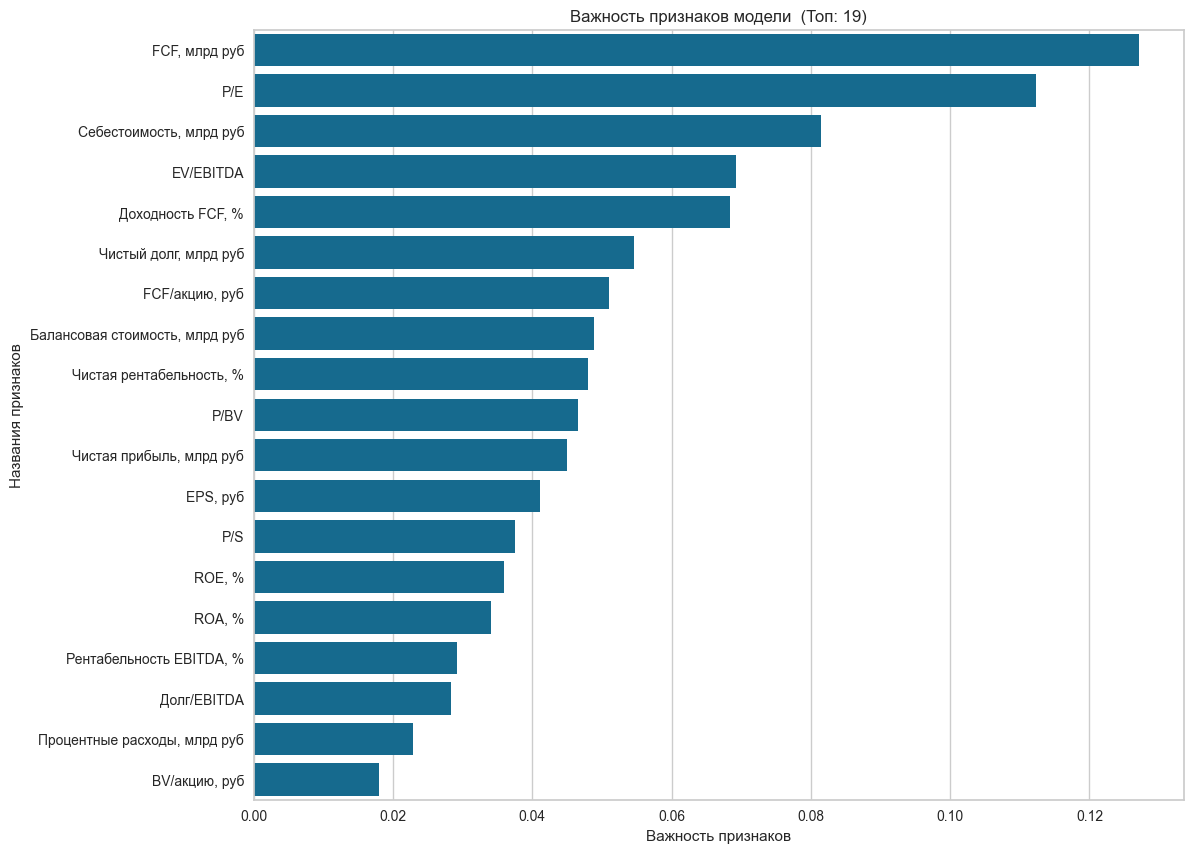

In [47]:
feat_imp = feature_importance_func(best_model_adasyn.feature_importances_, X_res.columns, top_n=X_res.shape[1], plot=True)

Видно, что все признаки имеют влияние на результат. При удалении даже наименее важного из них качество модели снизится

### Нахождение оптимального порога

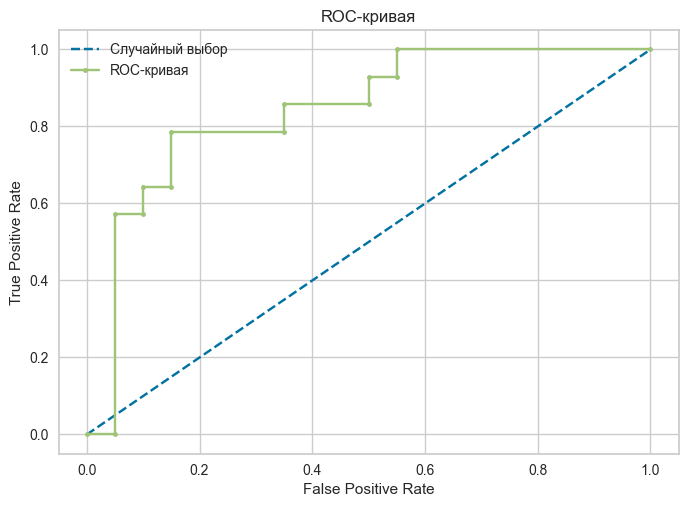

In [48]:
y_pred_proba = best_model_adasyn.predict_proba(X_test)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba[:, 1])

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайный выбор')
plt.plot(fpr, tpr, marker='.', label='ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

Порог=0.435361, Geom_mean=0.817


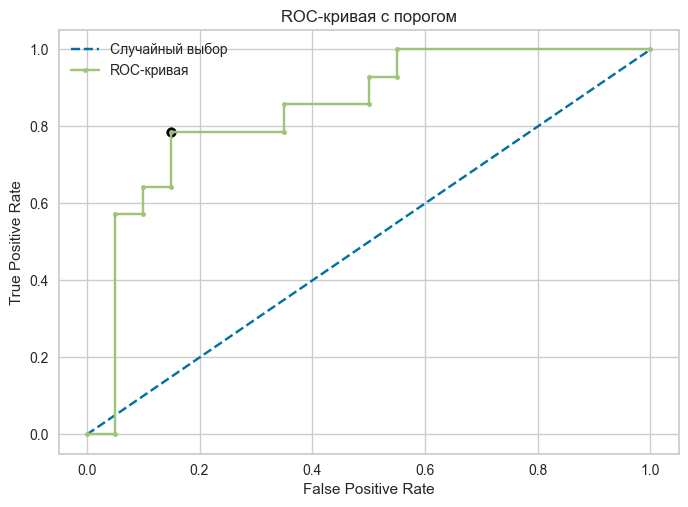

In [49]:
geom_mean = np.sqrt(tpr * (1 - fpr))
ix = argmax(geom_mean)
print('Порог=%f, Geom_mean=%.3f' % (roc_thresholds[ix], geom_mean[ix]))

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайный выбор')
plt.plot(fpr, tpr, marker='.', label='ROC-кривая')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая с порогом')
plt.legend()
plt.show()

In [50]:
# До нахождения порога
y_pred = best_model_ros.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73        20
           1       0.62      0.57      0.59        14

    accuracy                           0.68        34
   macro avg       0.66      0.66      0.66        34
weighted avg       0.67      0.68      0.67        34



In [51]:
# После нахождения порога
y_pred = (y_pred_proba[:, 1] > roc_thresholds[ix]).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        20
           1       0.77      0.71      0.74        14

    accuracy                           0.79        34
   macro avg       0.79      0.78      0.79        34
weighted avg       0.79      0.79      0.79        34



После нахождения порога, модель стала предсказывать более сбалансировано

Вывод: после проведения различных методов совершенствования модели, ключевую метрику ROC AUC score удалось увеличить с 0.7393 до **0.8429** 

# Заключение

### Результаты моделирования

По результатам моделирования лучшей моделью стал **XGBoost Classifier** с методом оверсемплинга ADASYN

In [52]:
y_pred_proba = best_model_adasyn.predict_proba(X_test)
y_pred = (y_pred_proba[:, 1] > roc_thresholds[ix]).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f'''Итоговые метрики:
ROC AUC score: {round(roc_auc, 4)}
F1-score: {round(f1, 4)}
Recall: {round(recall, 4)}
Precision: {round(precision, 4)}''')

Итоговые метрики:
ROC AUC score: 0.8429
F1-score: 0.7407
Recall: 0.7143
Precision: 0.7692


### Представление результатов в наглядном виде

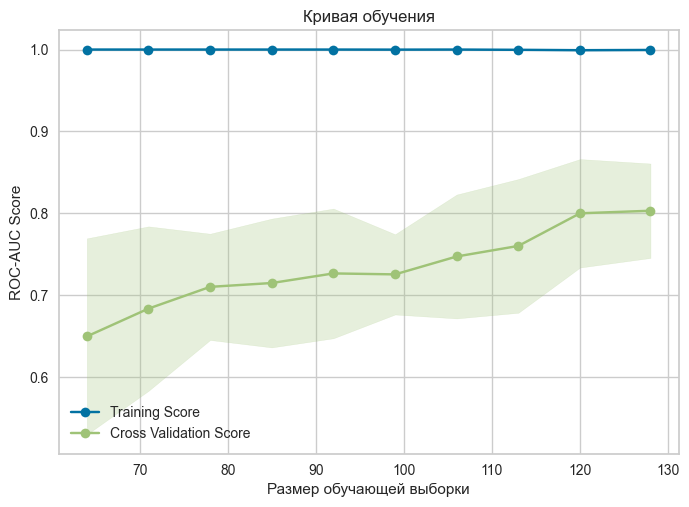

In [53]:
visualizer = LearningCurve(
    best_model_adasyn, train_sizes=np.linspace(0.5, 1.0, 10), scoring='roc_auc'
).fit(X_res, y_res)

plt.xlabel('Размер обучающей выборки')
plt.ylabel('ROC-AUC Score')
plt.title('Кривая обучения')
plt.legend(loc='best')
plt.show()

Видно, что модель немного переобучилась. Это может вызвано недостатком данных.

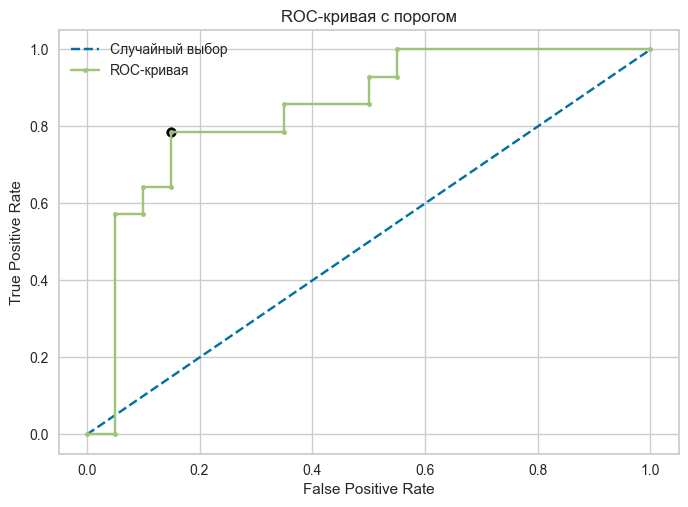

In [54]:
# Кривая ROC с порогом
geom_mean = np.sqrt(tpr * (1 - fpr))
ix = argmax(geom_mean)

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайный выбор')
plt.plot(fpr, tpr, marker='.', label='ROC-кривая')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая с порогом')
plt.legend()
plt.show()

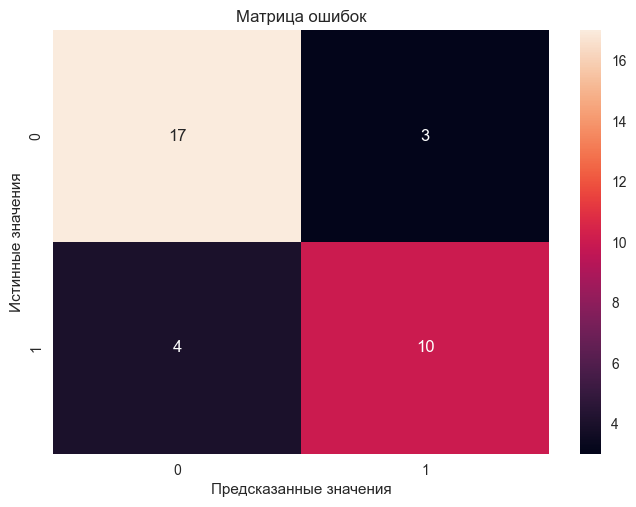

In [55]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show();

По матрице ошибок видно, что качество модели хорошее

['FCF, млрд руб', 'P/E', 'Себестоимость, млрд руб', 'EV/EBITDA', 'Доходность FCF, %', 'Чистый долг, млрд руб', 'FCF/акцию, руб', 'Балансовая стоимость, млрд руб', 'Чистая рентабельность, %', 'P/BV', 'Чистая прибыль, млрд руб', 'EPS, руб', 'P/S', 'ROE, %', 'ROA, %', 'Рентабельность EBITDA, %', 'Долг/EBITDA', 'Процентные расходы, млрд руб', 'BV/акцию, руб']


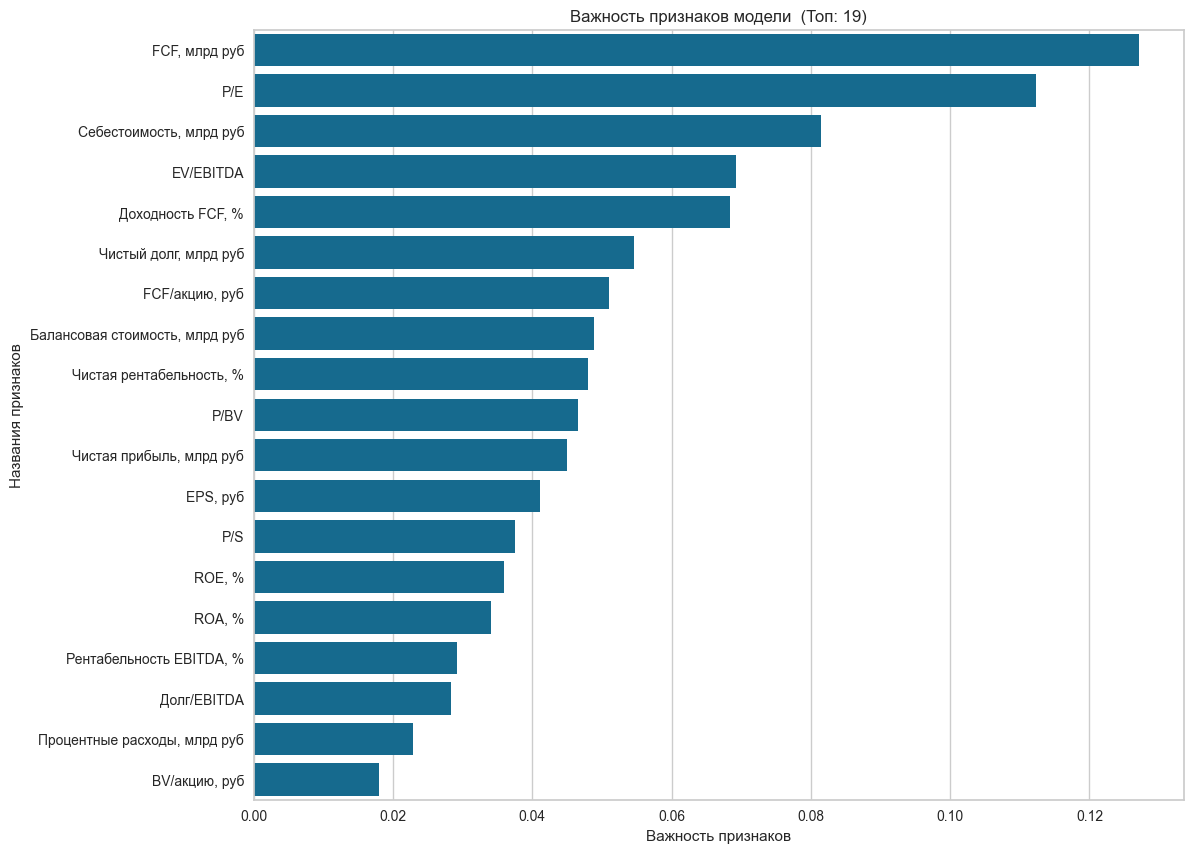

In [56]:
# Важность признаков
feat_imp = feature_importance_func(best_model_adasyn.feature_importances_, X_res.columns, top_n=X_res.shape[1], plot=True)

Согласно диаграмме важности признаков на определение наличия дивидендной доходности у компании больше всего влияет **FCF, млрд руб** и **P/E**

### Пример прогнозирования 

In [57]:
test_df = pd.read_excel('Финансовые показатели эмитентов.xlsx', sheet_name='Тестовые данные')
test_df

,№,Эмитент,Тикер,Наличие ДД,"Выручка, млрд руб","Операционная прибыль, млрд руб","EBITDA, млрд руб","Чистая прибыль, млрд руб","Операционный денежный поток, млрд руб","CAPEX, млрд руб",...,"Доходность FCF, %","ROE, %","ROA, %",P/E,P/FCF,P/S,P/BV,EV/EBITDA,Долг/EBITDA,Банковский сектор
0,1,Мечел,MTLR,0,406.2,64.90,86.40,22.30,64.30,10.50,...,0.092,-0.289,0.082,6.22,14.80,0.34,-1.71,4.21,2.61,0
1,2,ЛСР Группа,LSRG,1,236.2,62.50,77.70,28.40,29.80,11.50,...,0.655,0.239,0.060,3.43,1.53,0.41,0.85,1.92,0.66,0
2,3,ТГК-2,TGKB,0,49.6,3.42,6.26,-2.04,3.47,1.22,...,0.019,-0.049,-0.025,-9.64,53.20,0.40,0.47,4.83,1.69,0
3,4,Лента,LENT,0,693.3,21.70,43.90,5.41,53.40,13.30,...,-0.232,0.000,0.000,25.70,-4.31,0.20,NaN,5.45,2.29,0
4,5,МТС,MTSS,1,606.0,122.90,234.20,54.60,138.70,101.50,...,0.073,-10.696,0.042,11.30,13.80,1.02,-3.53,4.69,2.05,0
5,6,Газпром,GAZP,0,4114.0,744.80,1228.00,296.20,618.20,NaN,...,0.000,0.018,0.011,12.40,NaN,0.89,0.23,7.32,4.33,0
6,7,Роснефть,ROSN,1,9163.0,2182.00,3005.00,1267.00,2765.00,1297.00,...,0.231,0.151,0.067,4.88,4.33,0.67,0.74,2.06,0.00,0


Для тестовой выборки были взяты финансовые показатели компаний, полученные из отчетностей МСФО за 2023 год

In [58]:
X_test_df = test_df[X_train.columns]
y_test_df = test_df['Наличие ДД']
X_test_df = X_test_df.fillna(0)
X_test_df

,"Чистая прибыль, млрд руб","FCF, млрд руб","Себестоимость, млрд руб","Процентные расходы, млрд руб","Чистый долг, млрд руб","Балансовая стоимость, млрд руб","EPS, руб","FCF/акцию, руб","BV/акцию, руб","Рентабельность EBITDA, %","Чистая рентабельность, %","Доходность FCF, %","ROE, %","ROA, %",P/E,P/S,P/BV,EV/EBITDA,Долг/EBITDA
0,22.30,9.36,121.2,28.20,225.1,-81.5,53.6,22.5,-195.70,0.213,0.055,0.092,-0.289,0.082,6.22,0.34,-1.71,4.21,2.61
1,28.40,63.70,141.3,22.10,51.6,115.0,275.2,618.4,1117.00,0.329,0.120,0.655,0.239,0.060,3.43,0.41,0.85,1.92,0.66
2,-2.04,0.37,0.0,1.90,10.6,41.5,0.0,0.0,0.03,0.126,-0.041,0.019,-0.049,-0.025,-9.64,0.40,0.47,4.83,1.69
3,5.41,-32.20,385.8,6.64,100.5,0.0,46.6,-277.6,0.00,0.063,0.008,-0.232,0.000,0.000,25.70,0.20,0.00,5.45,2.29
4,54.60,44.80,215.6,46.30,480.4,-174.8,27.3,22.4,-87.50,0.387,0.090,0.073,-10.696,0.042,11.30,1.02,-3.53,4.69,2.05
5,296.20,0.00,0.0,0.00,5323.0,16054.0,12.5,0.0,678.20,0.298,0.072,0.000,0.018,0.011,12.40,0.89,0.23,7.32,4.33
6,1267.00,1427.00,4398.0,0.00,0.0,8414.0,119.6,134.6,793.90,0.328,0.138,0.231,0.151,0.067,4.88,0.67,0.74,2.06,0.00


In [59]:
adasyn = ADASYN(random_state=42)
X_res_full, y_res_full = adasyn.fit_resample(X, y)

In [60]:
best_model_ada_full = XGBClassifier(**params, reg_lambda=2, random_state=42).fit(X_res_full, y_res_full)

In [61]:
y_test_df_pred_proba = best_model_ada_full.predict_proba(X_test_df)
proba_table = pd.DataFrame({"Эмитент":test_df["Эмитент"], "Вероятность дивидендов":y_test_df_pred_proba[:,1]})
proba_table

,Эмитент,Вероятность дивидендов
0,Мечел,0.359796
1,ЛСР Группа,0.670620
2,ТГК-2,0.325220
3,Лента,0.361054
4,МТС,0.359796
5,Газпром,0.538184
6,Роснефть,0.657391


Наибольшую вероятность выплаты дивидендов имеют компании, действительно выплачивающие дивиденды

In [68]:
y_pred_proba_full = best_model_ada_full.predict_proba(X_test)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_full[:, 1])
geom_mean = np.sqrt(tpr * (1 - fpr))
ix = argmax(geom_mean)
print('Порог=%f, Geom_mean=%.3f' % (roc_thresholds[ix], geom_mean[ix]))

Порог=0.596787, Geom_mean=0.975


In [63]:
threshold = roc_thresholds[ix]
y_pred = (y_test_df_pred_proba[:, 1] > threshold).astype(int)
y_pred

array([0, 1, 0, 0, 0, 0, 1])

In [64]:
roc_auc_score(y_test_df, y_test_df_pred_proba[:, 1])

0.7916666666666666

In [65]:
proba_table["Наличие ДД - Факт"] = test_df["Наличие ДД"]
proba_table["Наличие ДД - Прогноз"] = y_pred

In [66]:
proba_table

,Эмитент,Вероятность дивидендов,Наличие ДД - Факт,Наличие ДД - Прогноз
0,Мечел,0.359796,0,0
1,ЛСР Группа,0.670620,1,1
2,ТГК-2,0.325220,0,0
3,Лента,0.361054,0,0
4,МТС,0.359796,1,0
5,Газпром,0.538184,0,0
6,Роснефть,0.657391,1,1


Только одно прогнозное значение не совпало с фактическим. 

Особое внимание стоит уделить компании Газпром. Важно отметить, что из-за снижения показателей данный эмитент может принять решение не выплачивать дивиденды за 2023 год так же, как это произошло по итогам 2022 года. На данный момент моделью прогнозируется, что Газпром откажется от выплаты дивидендов по итогам 2023 года.

С другой стороны, интересная ситуация наблюдается у МТС. Несмотря на фактическую выплату дивидендов, модельные прогнозы указывают на обратное. Это свидетельствует о том, что компания, вероятно, перераспределяет большую часть своих свободных средств на выплату дивидендов с целью поддержания стабильности котировок. Однако такая тактика может негативно сказаться на долгосрочной перспективе компании, поскольку это ограничивает ее возможности для инвестиций в стратегические проекты и развитие. Таким образом, долгосрочные перспективы МТС остаются неопределенными и требуют дополнительного внимания со стороны инвесторов и аналитиков.

# Выводы

В результате проведения анализа данных и построения признаков для оценки наличия дивидендной доходности у компаний была разработана модель с высокой точностью предсказаний. В ходе исследования было обнаружено, что наличие дивидендов у компании в значительной степени зависит от двух ключевых показателей: свободного денежного потока (FCF) и коэффициента цены к прибыли (P/E). FCF отражает доступные средства, которые можно извлечь из бизнеса без вреда его будущей деятельности, в то время как P/E представляет собой отношение цены акций к ее прибыли.

Разработанная модель предоставляет возможность предсказать вероятность выплаты дивидендов. Это имеет большое значение для инвесторов, поскольку позволяет выявлять недооцененные компании, которые не выплачивают дивиденды, но подходят к пороговым значениям в модели или даже превышают их, что приводит к ошибочному прогнозу. Важно отметить, что такие ошибки могут послужить триггером для принятия решения о покупке акций данной компании. Это открывает новые перспективы для инвесторов, помогая им принимать обоснованные решения на основе анализа данных и моделирования.